# Importación de librerías  

In [36]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
warnings.filterwarnings('ignore')

# Cargue de datos

En este proceso de Cargue de Datos, se utilizó el archivo CSV depurado obtenido tras un análisis preliminar de los datos originales del estudio "Medición de Pobreza Monetaria y Desigualdad 2023" del DANE. Este análisis incluyó la limpieza, transformación e imputación de valores nulos, asegurando que los datos sean consistentes y estén preparados para la fase de segmentación mediante técnicas de clustering. 

In [3]:
# Leer archivos csv
def leer_archivos (path):
    """
    Lee un archivo csv y retorna un dataframe
    :param path: str: path del archivo csv
    :return: DataFrame: dataframe con los datos del archivo
    """
    df = pd.read_csv(path)
    return df

data = leer_archivos("../data/clean/pobreza_desigualdad.csv")
data.head()

,tipo_area,region,tenencia_viv,linea_indig,linea_pobreza,hogar_pobre,hogar_indigente,num_pobres,num_indigentes,factor_exp,...,jh_genero,jh_edad,jh_afiliado_seguridad_social,jh_nivel_educativo,jh_situacion_laboral,jh_cotizacion_pension,jh_posicion_ocupacional,jh_horas_trabajo_semanales,total_dependientes,ingreso_per_capita
0,cabecera,RESTO URBANO,En arriendo o subarriendo,211838.33655,393677.759609,no,no,0,0,131.723106,...,Femenino,32,Si,Tecnológica,Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",1.0,7.333361e+05
1,cabecera,RESTO URBANO,"Propia, la están pagando",211838.33655,393677.759609,no,no,0,0,83.471732,...,Femenino,48,Si,Técnica profesional,Trabajando,Si,Trabajador por cuenta propia,Más de 40 horas,0.0,1.425000e+06
2,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,Masculino,68,Si,Media académica (Bachillerato clásico),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,5.000000e+05
3,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,Masculino,80,Si,Básica primaria (1o - 5o),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,7.333333e+04
4,resto,RURAL,En arriendo o subarriendo,164635.13660,270748.848811,no,no,0,0,27.049855,...,Femenino,39,Si,Media académica (Bachillerato clásico),Oficios del hogar,No,Trabajador por cuenta propia,Más de 40 horas,2.0,3.956002e+06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277158 entries, 0 to 277157
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   tipo_area                     277158 non-null  object 
 1   region                        277158 non-null  object 
 2   tenencia_viv                  277158 non-null  object 
 3   linea_indig                   277158 non-null  float64
 4   linea_pobreza                 277158 non-null  float64
 5   hogar_pobre                   277158 non-null  object 
 6   hogar_indigente               277158 non-null  object 
 7   num_pobres                    277158 non-null  int64  
 8   num_indigentes                277158 non-null  int64  
 9   factor_exp                    277158 non-null  float64
 10  total_personas_hogar          277158 non-null  int64  
 11  ingresos_laborales            277158 non-null  float64
 12  ingresos_subsidios            277158 non-nul

El DataFrame analizado `data` contiene un total de 277,158 registros y 30 columnas, proporcionando un conjunto de datos detallados sobre las características socioeconómicas de los hogares en Colombia. Las columnas incluyen variables categóricas, como `tipo_area`, `region`, y `tenencia_viv`, que representan aspectos geográficos y de vivienda, así como variables numéricas que abarcan desde ingresos y composición del hogar hasta indicadores de pobreza. 

Entre las variables numéricas, se encuentran datos críticos como `num_pobres`, `total_ingresos_hogar`, e `ingreso_per_capita`, que son fundamentales para el análisis de la pobreza y la desigualdad. 

Además, el DataFrame incluye información sobre la situación laboral y educativa del jefe de hogar a través de columnas como `jh_situacion_laboral`, `jh_nivel_educativo`, y `jh_horas_trabajo_semanales`. Las columnas no presentan valores nulos. Sobre este conjunto de datos, se llevó a cabo un análisis descriptivo y aplicar técnicas de segmentación y clustering con el fin de abordar la segmentación de los hogares de manera precisa, lo que permitirá a CARE diseñar e implementar estrategias de intervención más específicas y efectivas.

# Análisis descriptivo y visualización

Se realizó el estudio de las variables numéricas y categóricas contenidas en el dataframe `data`. Este análisis tiene como objetivo comprender la distribución, tendencias y posibles relaciones entre las variables, tanto numéricas como categóricas, que describen las características de los hogares. A partir de esta exploración, se identificaron variables cruciales para el proceso de segmentación, permitiendo optimizar el dataset para el posterior uso en técnicas de clustering, mejorando así los tiempos de ejecución y el costo computacional.

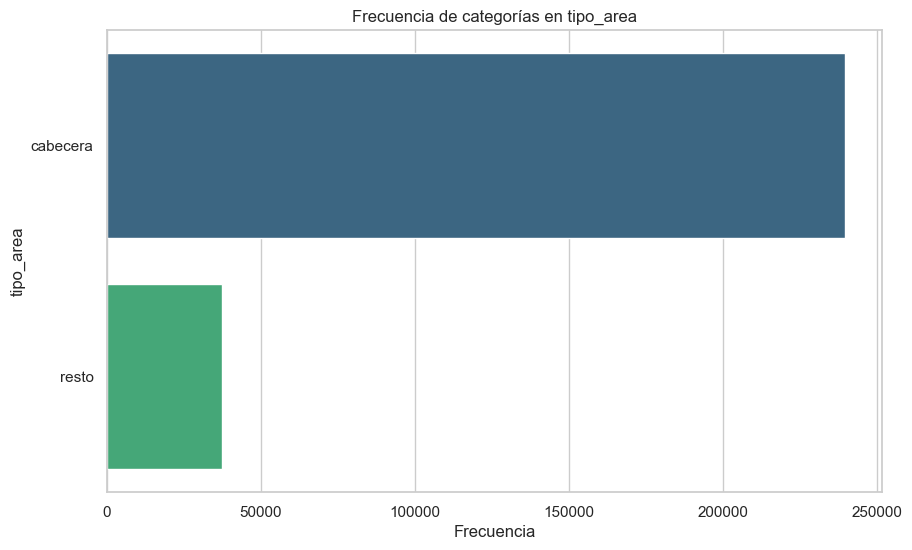

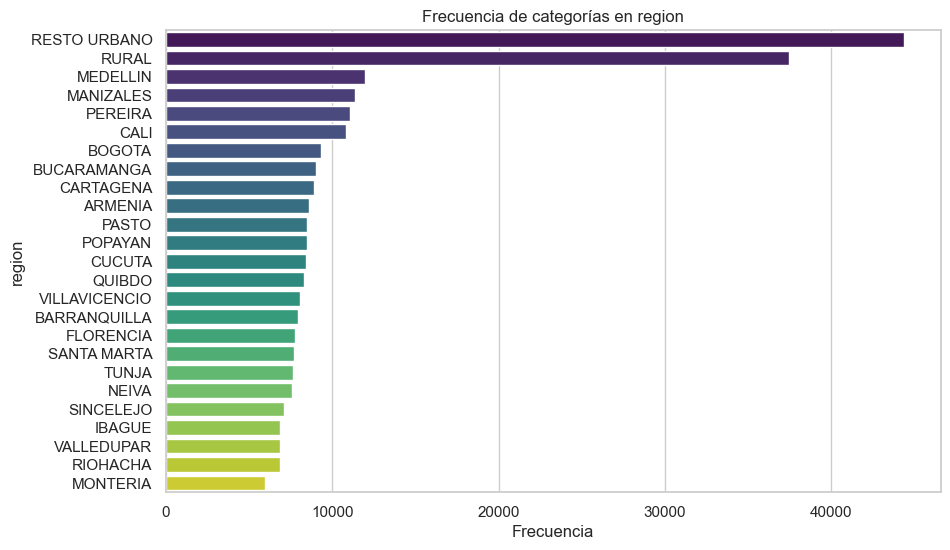

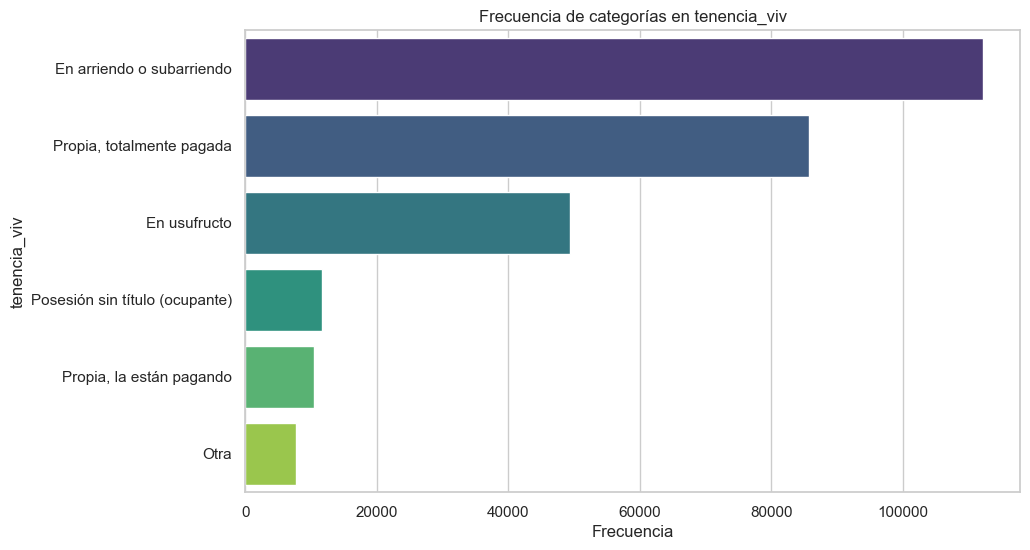

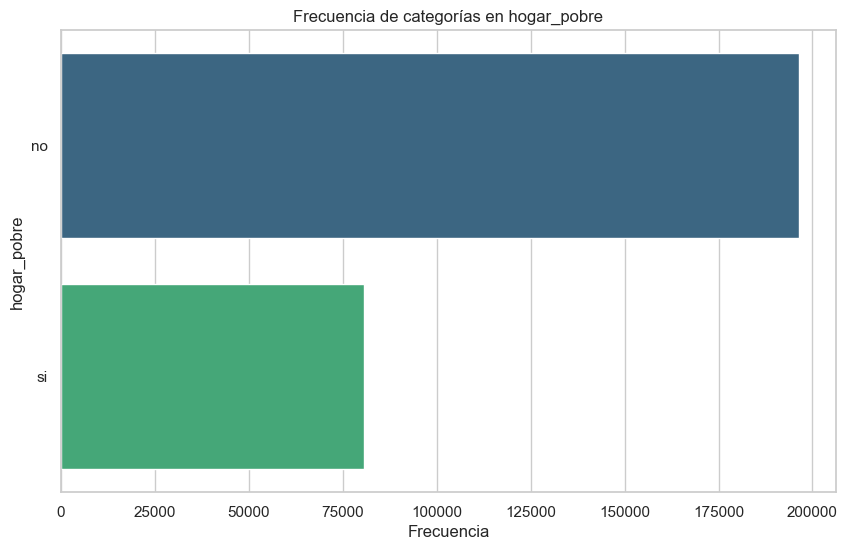

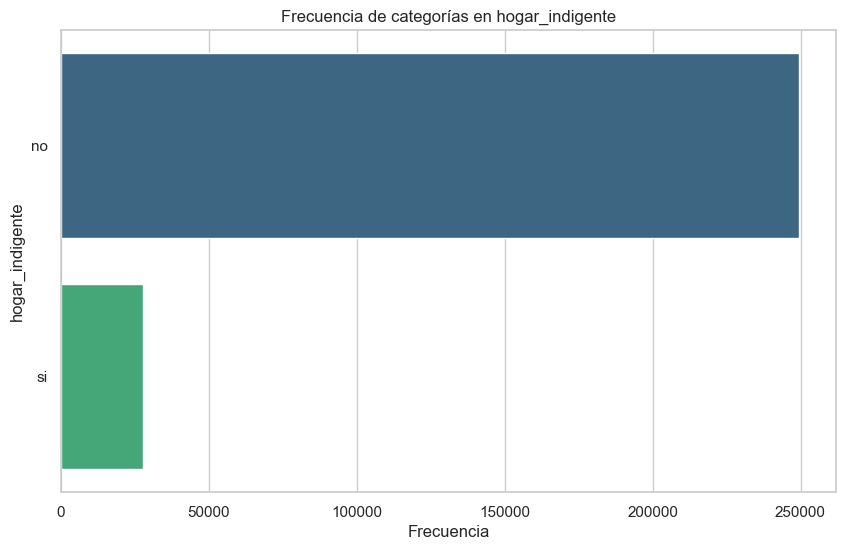

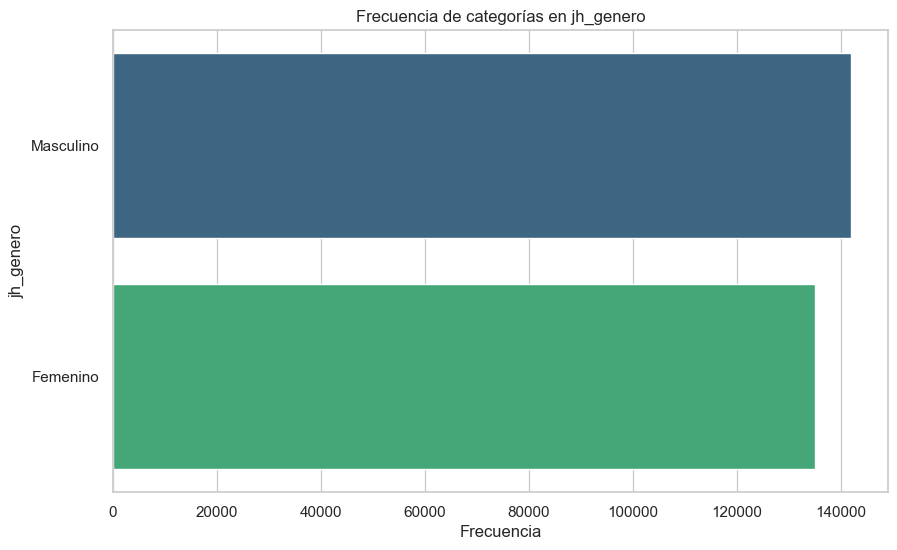

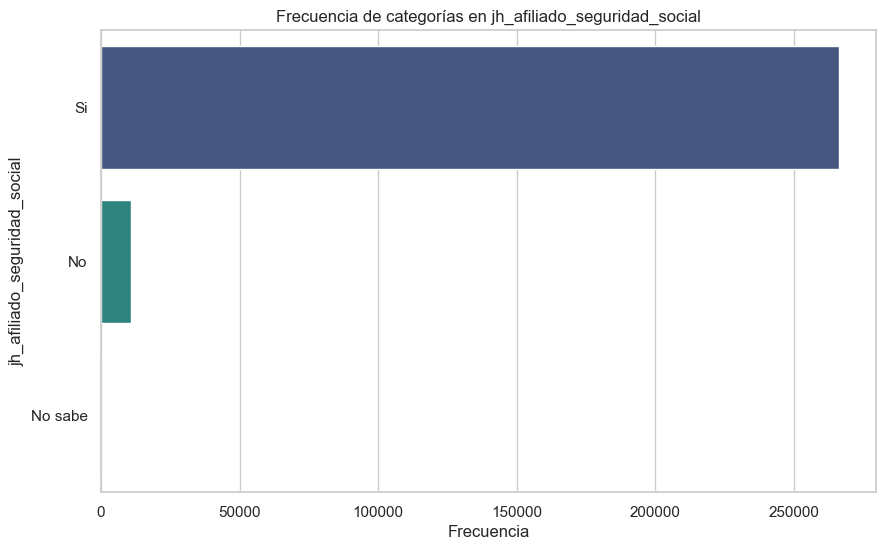

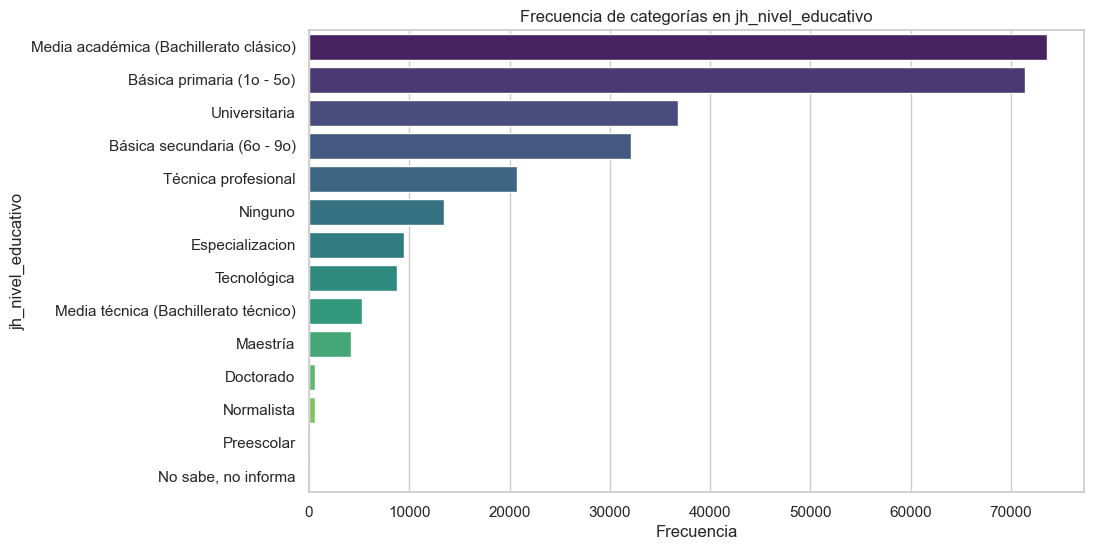

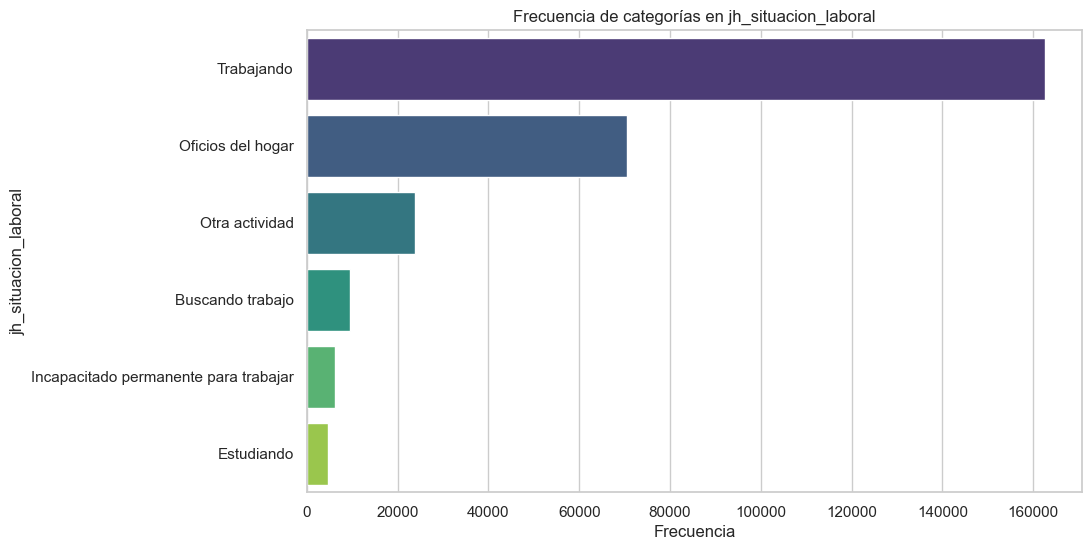

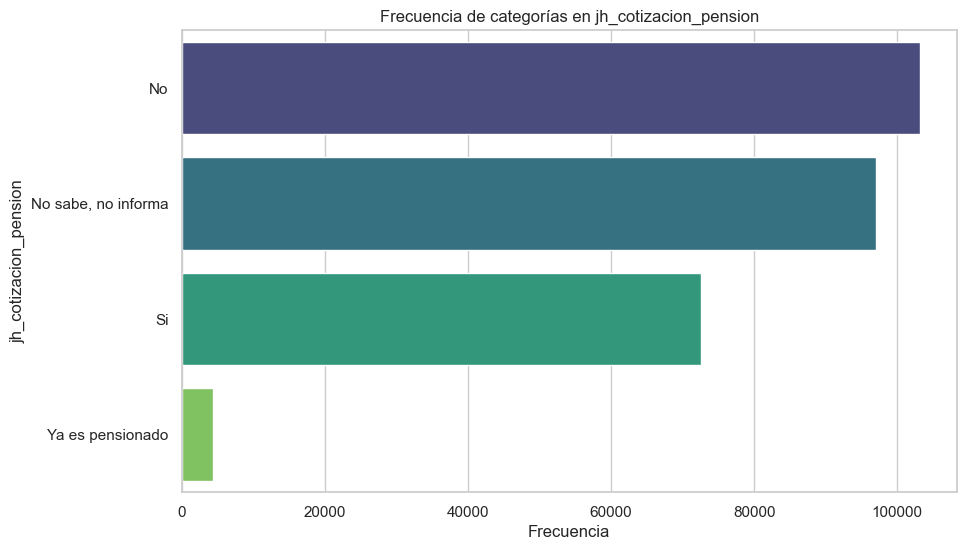

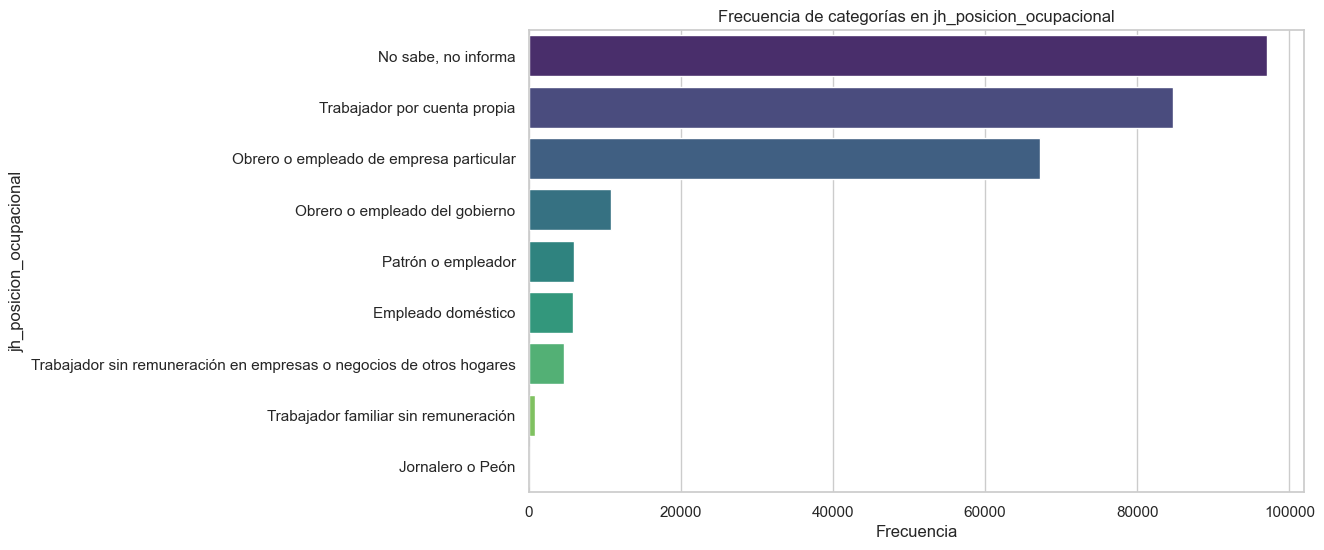

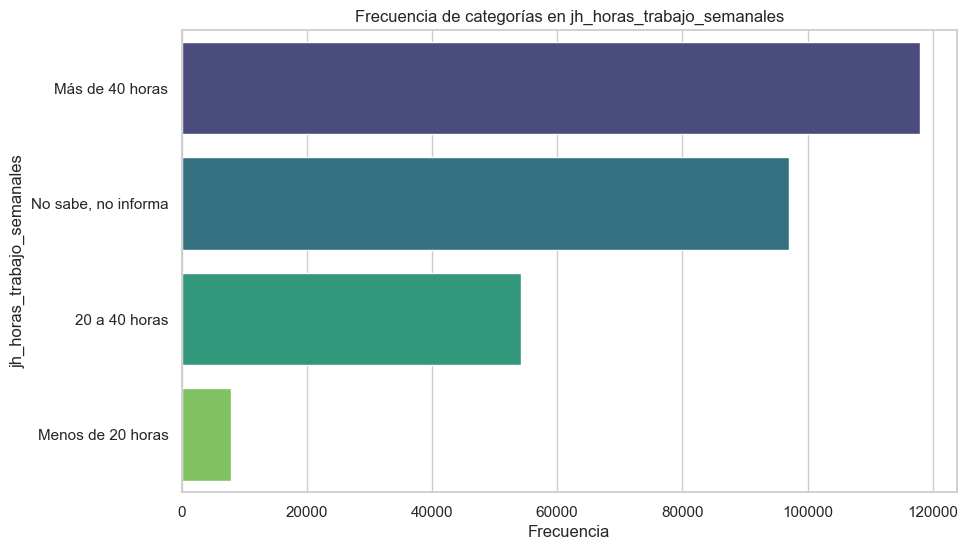

In [5]:
# Función para crear gráficos de barras horizontales para variables categóricas de forma independiente
def graficar_variables_categoricas(df):
    """
    Crea gráficos de barras horizontales para las columnas categóricas de tipo object en el DataFrame
    en gráficos independientes.

    Parameters:
        df (pd.DataFrame): DataFrame que contiene los datos.
    """
    # Filtrado de las columnas de tipo object
    columnas_categoricas = df.select_dtypes(include=['object']).columns
    
    # Configuración del estilo de Seaborn
    sns.set(style='whitegrid', palette='viridis')
    
    # Creación de un gráfico independiente para cada columna categórica
    for col in columnas_categoricas:
        # Cálculo de la frecuencia de cada categoría
        frecuencia = df[col].value_counts().reset_index()
        frecuencia.columns = [col, 'frecuencia']

        # Creación del gráfico de barras horizontales
        plt.figure(figsize=(10, 6))
        sns.barplot(data=frecuencia, x='frecuencia', y=col, palette='viridis')
        plt.title(f'Frecuencia de categorías en {col}')
        plt.xlabel('Frecuencia')
        plt.ylabel(col)
        plt.show() 

graficar_variables_categoricas(data)

**Interpretación de resultados**

* `tipo_area`clasifica los hogares en dos categorias: **cabecera** y **resto**. Predominan los hogares en áres de cabecera con una participación de 86.49% en comparación con los hogares ubicados en zonas rurales o menos urbanizadas (13.51%)
* `region`categoriza los hogares segun diferentes ubicacione geográficas en Colombia. La mayoría de los hogares se concentra en áreas urbana, especialmente en ciudades como **Medellín**, **Cali** y **Bogotá**. Las regiones rurales también tienen una representación significativa (13.51%), lo que indica que es importante considerar sus características al realizar la segmentación.
* `tenencia_viv`describe la situación de tenencia de la vivienda entre los hogares de estudio. Si bien, una alta proporción de hogares viven en arriendo o subarriendo (40.49%), otra proporción significativa de hogares posee su vivienda formal (30.91%). Existen tambien un porcentaje pequeño (4.73%) de hogares qen posición sin titulo y aquellos en proceso de pago (3.77%) que pudieran llegar a necesitar apoyo para la formalización de la propiedad y el acceso a la vivienda. 
* `hogar_pobre`indica la situación de pobreza de los hogares en el estudio. La mayoría de estos no se consideran pobres (70.87%), lo que es un indicador positivo de bienestar económico en una parte de la población. Sin embargo, el 29.23% de los hogares clasifican como pobres, sugiere la existencia de una población vulnerable que enfrenta desafíos significativos.
* `hogar_indigente`refleja la situación de indigencia de los hogares en estudio. La mayoria de los hogares (90.03%) no se consideran en indigencia, lo que es un indicador positivo a nivel general de bienestar en la población. No obstante el 10% de la población si clasifica como indigentes y resalta la necesidad de identificar las circunstancias de estos hogares que son candidatos a futuras intervenciones de la ONG Care.
* `jh_genero` representa el género del jefe de hogar. La distribución de géneros está relativamente equilibrada, con una ligera predominancia másculina (51.24%). La proporción significativa de hogares liderados por mujeres (48.76%) destaca la importancia de considerar las necesidades y desafíos específicos que enfrentan las familias con jefas femeninas dentro del contexto de la pobreza y acceso a recursos.
* `jh_afiliado_seguridad_social`indica si el jefe de hogar está afiliado a algun sistema de seguridad social en salud. La mayoría de los jefes de hogar se encuentra afiliado a un sistema de seguridad social(90.06%), lo que es un indicador positivo en términos de acceso a servicios de salud. No obstante un porcentaje pequeño (3.88%) no esta afiliado a ningún sistema de seguridad social, representando un grupo de la población que puede verse expuesto a riesgos de salud sin la cobertura adecuada. 
* `jh_nivel_educativo`refleja el nivel educativo del jefe del hogar. La mayoría de los jefes de hogar tienen al menos educación primaria, pero hay una notable caída en los niveles educativos superiores, lo que puede implicar barreras en el acceso a la educación y a oportunidades de desarrollo personal y profesional. En 4.87% de los hogares, el jefe de hogar no cuenta con educación formal, sugiriendo la implementación de iniciativas educativas y programas de concientización. 
* `jh_situacion_laboral`describe la situación laboral del jefe de hogar. La mayoría de los jefes de hogar estan en situación de trabajo (58.66%) lo que sugiere una economía activa y en movimiento. Una parte significativa de los jefes de hogar (25.44%) esta involucrado en oficidos de hogar, lo que puede subrayar la importancia del trabajo no remunerado en la estructura familiar y económica. Hay un bajo porcentaje de jefes de hogar estudiando (1.64%) y buscando trabajo (3.42%) lo que podria indicar barreras para la educación y el empleo, afectando el desarrollo económico y social. La pequeña proporción de personas incapacitadas para trabajar (2.21%) también merece atención para el desarrollo de políticas inclusivas. 
* `jh_cotizacion_pension` indica la situación de cotización a pensión del jefe de hogar. La mayor parte de los jefes de hogar no están cotizando a pensiones (37.22%) lo que sugiere que una gran parte de la población podría estar en riesgo de no tener un ingreso estable en la jubilación. Hay una proporción significa de jefes de hogar (35.01%) que no saben o no informan su situación de cotización y solo el 26.20% de los jefes de hogar está cotizando a pensiones. La baja tasa de personas pensionadas (1.57%) sugiere que la mayoría de los jefes de hogar aun tienen por delante en la fuerza laboral.
* `jh_posicion_ocupacional`representa la situación labora del jefe del hogar en terminos de su posición ocupacional. Una alta proporción de las personas encuestadas no saben o no proporcionan información de su posición ocupacional (35.01%), lo que destaca la necesidad de mejorar la recopilación de datos y la concientización sobre la situación laboral. La gran cantidad de trabajadores por cuenta propia (30.55%) sugiere una economia informal lo que podría tener implicaciones para el acceso a beneficios sociales y laborales. La representación relativamente baja de empleados del gobierno (3.92%) puede ser un reflejo de la estructura del pais, donde el sector privado es predominante. Las posiciones con menos representación (empleados domésticos, trabajadores sin remuneración) reflejan la diversidad de fuerza laboral y existencia de trabajo informal en la economía.
* `jh_horas_trabajo_semanales` refleja la cantidad de horas que el jefe e hogar trabaja en una semana. La proporción de hogares donde el jefe trabaja mas de 40 horas a la semana es 42.55%, lo cual es un reflejo de la legislación laboral colombiana actual en donde la jornada laboral tiene un máximo de 46 horas. La cantidad significativa de personas que no sabe o no informa sobre sus horas de trabajo (35.01%) refleja la necsidad de de mejorar la recolección de datos por parte del DANE. Finalmente una proporción pequeña de jefes de hogar (2.84%) trabajan menos de 20 horas, lo que sugiere que esta población tenga un empleo a tiempo parcial, generando efectos en la estabilidad financiera y la calidad de vida del hogar.

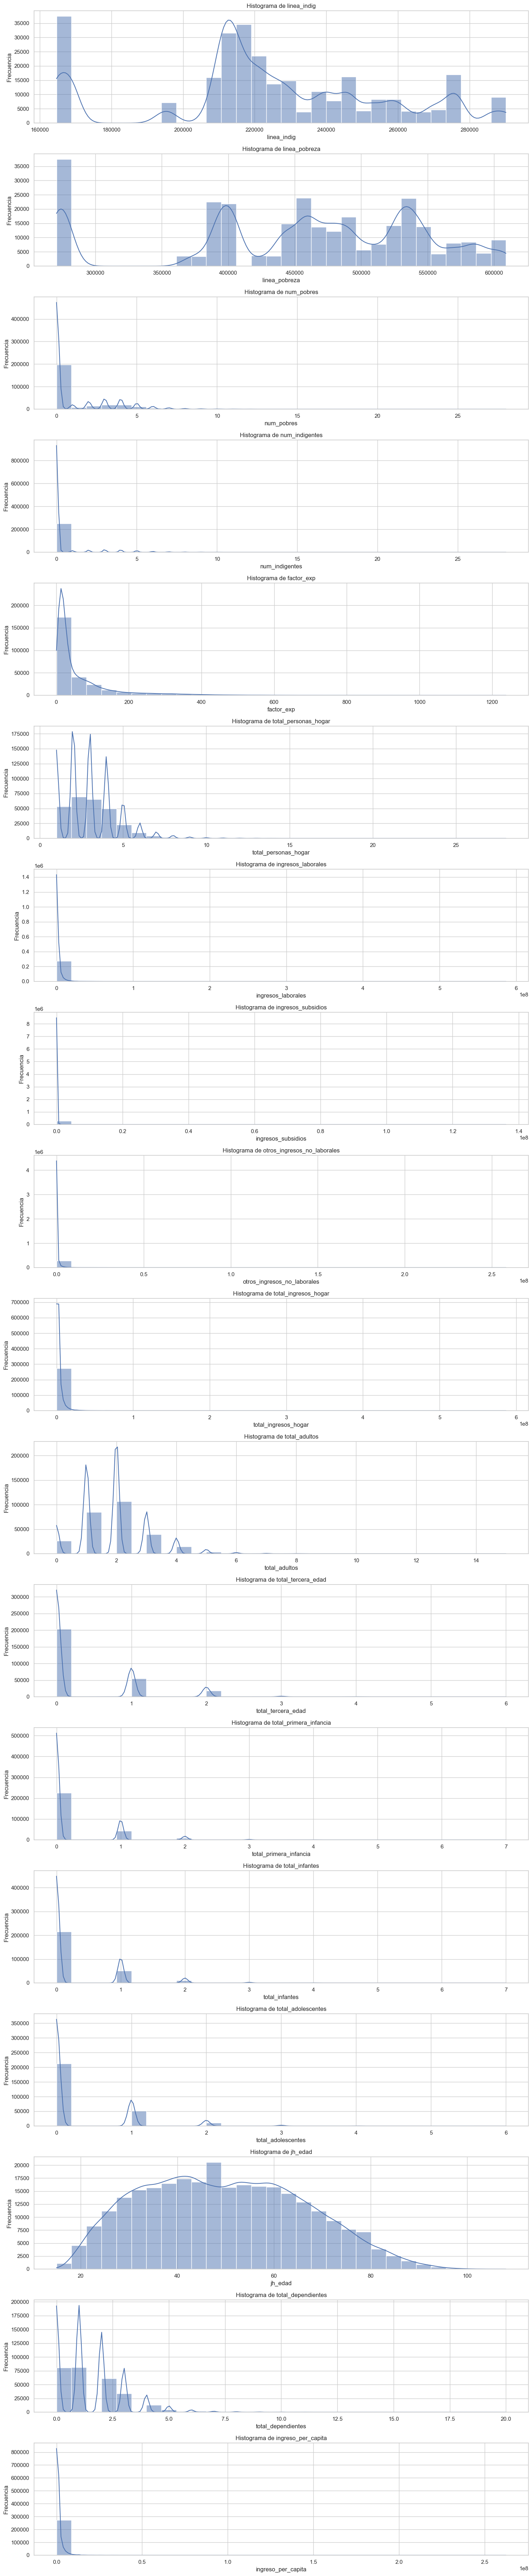

In [5]:
# Filtrado de las columnas numéricas
columnas_numericas = data.select_dtypes(include=['float64', 'int64']).columns

# Configuración del estilo de Seaborn
sns.set(style='whitegrid')

# Creación de boxplots para cada variable numérica
plt.figure(figsize=(15, len(columnas_numericas) * 4)) 
for i, col in enumerate(columnas_numericas):
    plt.subplot(len(columnas_numericas), 1, i + 1)
    sns.histplot(data[col], bins=30, kde=True, palette='viridis')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Interpretación de resultados**

* `linea_indig` la mayoría de los hogares se encuentran por encima de la línea de indigencia, pero con una desviación estandar considerable, lo que indica una amplia variación en los ingresos. 
* `linea_pobreza` Similar a la línea de indigencia, la linea de pobreza presenta una variabilidad notable, sugiriendo que hay hogares con ingresos muy distintos, incluso dentro de la pobreza.
* `num_pobres` la mayoría de los hogares reporta 1 o ningún miembro en situación de pobreza, aunque hay algunos hogares hasta con 28 personas en esta situación, lo que puede indicar graves problemas en la economía familiar. 
* `num_indigentes` Al igual que en las anteriores variables, la media sugiere que pocos hogares tienen indigentes, pero el valor máximo (28 personas) indica que algunos hogares están enfrentando crisis extremas. 
* `factor_exp`Este factor de expansión de los datos, tiene una alta variabilidad, lo que sugiere que algunas áreas están mucho más representadas que otras en la muestra. 
* `total_personas_hogar`: Un promedio de aproximadamente 3 personas por hogar es típico en muchas regiones, pero el rango máximo indica la posibilidad de hogares muy grandes (28 personas), lo que puede complicar la gestión de sus recursos.
* `ingresos_laborales`: La media (2481285) indica que muchos hogares dependen de ingresos laborales, aunque la alta desviación estándar (5289516) muestra una gran desigualdad en la remuneración. 
* `ingresos_subsidios`: Muchos hogares no dependen de subsidios, pero algunos reciben cantidades significativas, sugiriendo un sistema de ayuda muy variable. 
* `total_ingresos_hogar`: Existe una disparidad económica donde algunos hogares son mucho más ricos que otros, distorsionando la media (3.180.801)
* `ingreso_per_capita`:  El ingreso per cápita refuerza la desigualdad observada en los ingresos totales. 

En conclusión: 

* Desigualdad Económica: Los altos valores de desviación estándar en casi todas las variables sugieren una notable desigualdad económica entre los hogares, donde algunos enfrentan condiciones extremas mientras que otros están mucho mejor.
* Dependencia de Ingresos Laborales: La mayoría de los hogares dependen de ingresos laborales, pero la variabilidad de estos ingresos sugiere que se deben implementar políticas para mejorar las oportunidades de empleo y aumentar los salarios.
* Efecto de los Subsidios: Aunque los subsidios juegan un papel en la economía de algunos hogares, muchos no reciben ayuda, lo que puede aumentar la vulnerabilidad económica.
* Demografía del Hogar: El tamaño de los hogares es un factor importante a considerar en la formulación de políticas, especialmente en lo que respecta a la asignación de recursos y programas de asistencia.

# Selección de Variables

El objetivo principal del proyecto es segmentar los hogares de manera precisa, lo que permitirá a CARE diseñar e implementar estrategias de intervención más específicas y efectivas. Por esta razón priorizamos las variables que mejor representan las características de hogares y reducir el tamaño del dataset para hacerlo manejable. 

In [4]:
data_cleaned = data.copy()

### 1. Identificación de columnas con baja variabilidad:

Las columnas con baja variabilidad son aquellas en las que la mayoría de los valores son iguales. Estas variables no proporcionan información valiosa para el clustering, ya que no ayudan a diferenciar entre los hogares. ¿Cómo las identificamos? Calculamos la frecuencia del valor más común en cada columna. Si la frecuencia de este valor es muy alta (por ejemplo, más del 95%), eliminamos esa columna.

In [5]:
# Cálculo de la proporción del valor más frecuente en cada columna
low_variability_columns = []

for column in data_cleaned.columns:
    freq = data[column].value_counts(normalize=True).values[0]
    if freq > 0.95:  # Si más del 95% de los valores son iguales
        low_variability_columns.append(column)

print(f"Columnas con baja variabilidad: {low_variability_columns}")

# Borrado columnas con baja variabilidad
data_cleaned = data_cleaned.drop(columns=low_variability_columns)
data_cleaned.head()

Columnas con baja variabilidad: ['jh_afiliado_seguridad_social']


,tipo_area,region,tenencia_viv,linea_indig,linea_pobreza,hogar_pobre,hogar_indigente,num_pobres,num_indigentes,factor_exp,...,total_adolescentes,jh_genero,jh_edad,jh_nivel_educativo,jh_situacion_laboral,jh_cotizacion_pension,jh_posicion_ocupacional,jh_horas_trabajo_semanales,total_dependientes,ingreso_per_capita
0,cabecera,RESTO URBANO,En arriendo o subarriendo,211838.33655,393677.759609,no,no,0,0,131.723106,...,0,Femenino,32,Tecnológica,Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",1.0,7.333361e+05
1,cabecera,RESTO URBANO,"Propia, la están pagando",211838.33655,393677.759609,no,no,0,0,83.471732,...,0,Femenino,48,Técnica profesional,Trabajando,Si,Trabajador por cuenta propia,Más de 40 horas,0.0,1.425000e+06
2,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,0,Masculino,68,Media académica (Bachillerato clásico),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,5.000000e+05
3,cabecera,RESTO URBANO,En usufructo,211838.33655,393677.759609,no,no,0,0,106.360970,...,0,Masculino,80,Básica primaria (1o - 5o),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,7.333333e+04
4,resto,RURAL,En arriendo o subarriendo,164635.13660,270748.848811,no,no,0,0,27.049855,...,1,Femenino,39,Media académica (Bachillerato clásico),Oficios del hogar,No,Trabajador por cuenta propia,Más de 40 horas,2.0,3.956002e+06


### 2. Análisis de correlación y multicolinealidad

Aquí buscamos identificar aquellas variables numéricas que están altamente correlacionadas entre sí y eliminar las redundantes.

In [39]:
# Selección de las columnas numéricas
numeric_data = data_cleaned.select_dtypes(include=['float64', 'int64'])

# Cálculo de la matriz de correlación (valor absoluto para centrarse en la magnitud)
corr_matrix = numeric_data.corr().abs()

# Matriz de correlación
corr_matrix

,linea_indig,linea_pobreza,num_pobres,num_indigentes,factor_exp,total_personas_hogar,ingresos_laborales,ingresos_subsidios,otros_ingresos_no_laborales,total_ingresos_hogar,total_adultos,total_tercera_edad,total_primera_infancia,total_infantes,total_adolescentes,jh_edad,total_dependientes,ingreso_per_capita
linea_indig,1.000000,0.917802,0.033906,0.059327,0.091538,0.047917,0.127480,0.025309,0.084796,0.094581,0.012935,0.011476,0.066873,0.048437,0.040649,0.023968,0.082202,0.064607
linea_pobreza,0.917802,1.000000,0.051999,0.080997,0.123737,0.058685,0.132494,0.028869,0.102287,0.093978,0.015761,0.000363,0.084986,0.065733,0.055600,0.013556,0.100424,0.061612
num_pobres,0.033906,0.051999,1.000000,0.539555,0.030787,0.532907,0.123179,0.055961,0.144387,0.157813,0.251760,0.056579,0.373178,0.387534,0.351190,0.122560,0.615851,0.205671
num_indigentes,0.059327,0.080997,0.539555,1.000000,0.011936,0.297494,0.089989,0.002779,0.081447,0.110266,0.086908,0.036886,0.246908,0.263428,0.227278,0.078134,0.382567,0.122525
factor_exp,0.091538,0.123737,0.030787,0.011936,1.000000,0.005593,0.080926,0.015317,0.020065,0.070722,0.000346,0.039974,0.015639,0.012593,0.002627,0.038306,0.009149,0.064418
total_personas_hogar,0.047917,0.058685,0.532907,0.297494,0.005593,1.000000,0.116532,0.164039,0.045983,0.106153,0.733437,0.000041,0.463328,0.493278,0.467766,0.080488,0.893885,0.156633
ingresos_laborales,0.127480,0.132494,0.123179,0.089989,0.080926,0.116532,1.000000,0.012894,0.019526,0.946837,0.179784,0.069189,0.014993,0.019355,0.016479,0.044515,0.023140,0.774961
ingresos_subsidios,0.025309,0.028869,0.055961,0.002779,0.015317,0.164039,0.012894,1.000000,0.050533,0.064694,0.126551,0.023869,0.092383,0.079032,0.077845,0.045851,0.140111,0.002284
otros_ingresos_no_laborales,0.084796,0.102287,0.144387,0.081447,0.020065,0.045983,0.019526,0.050533,1.000000,0.332755,0.116865,0.298631,0.086304,0.081877,0.069090,0.265589,0.038791,0.340449
total_ingresos_hogar,0.094581,0.093978,0.157813,0.110266,0.070722,0.106153,0.946837,0.064694,0.332755,1.000000,0.140489,0.028269,0.007003,0.002414,0.001132,0.039443,0.019032,0.836329


In [40]:
# Quedarse con la parte superior de la matriz de correlación
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar las columnas con correlación mayor a 0.9
highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

print(f"Columnas altamente correlacionadas: {highly_correlated}")

Columnas altamente correlacionadas: ['linea_pobreza', 'total_ingresos_hogar']


In [6]:
# Borrado de columnas altamente correlacionadas. 
data_cleaned = data_cleaned.drop(columns=['linea_pobreza'])
data_cleaned.head()

,tipo_area,region,tenencia_viv,linea_indig,hogar_pobre,hogar_indigente,num_pobres,num_indigentes,factor_exp,total_personas_hogar,...,total_adolescentes,jh_genero,jh_edad,jh_nivel_educativo,jh_situacion_laboral,jh_cotizacion_pension,jh_posicion_ocupacional,jh_horas_trabajo_semanales,total_dependientes,ingreso_per_capita
0,cabecera,RESTO URBANO,En arriendo o subarriendo,211838.33655,no,no,0,0,131.723106,3,...,0,Femenino,32,Tecnológica,Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",1.0,7.333361e+05
1,cabecera,RESTO URBANO,"Propia, la están pagando",211838.33655,no,no,0,0,83.471732,2,...,0,Femenino,48,Técnica profesional,Trabajando,Si,Trabajador por cuenta propia,Más de 40 horas,0.0,1.425000e+06
2,cabecera,RESTO URBANO,En usufructo,211838.33655,no,no,0,0,106.360970,1,...,0,Masculino,68,Media académica (Bachillerato clásico),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,5.000000e+05
3,cabecera,RESTO URBANO,En usufructo,211838.33655,no,no,0,0,106.360970,1,...,0,Masculino,80,Básica primaria (1o - 5o),Otra actividad,"No sabe, no informa","No sabe, no informa","No sabe, no informa",0.0,7.333333e+04
4,resto,RURAL,En arriendo o subarriendo,164635.13660,no,no,0,0,27.049855,5,...,1,Femenino,39,Media académica (Bachillerato clásico),Oficios del hogar,No,Trabajador por cuenta propia,Más de 40 horas,2.0,3.956002e+06


### 3. Medición de la importancia de Características con Árboles de decisión (Random Forest)

La variable `hogar_pobre` fue seleccionada de manera arbitraria como un referente en el proceso de selección de características debido a su relación directa con el objetivo general del proyecto: *segmentar hogares en función de condiciones de pobreza y desigualdad*. Aunque el objetivo del proyecto es aplicar un enfoque de aprendizaje no supervisado para identificar patrones mediante clustering, utilizar una variable categórica como `hogar_pobre` en el análisis preliminar permite evaluar la relevancia de otras variables en términos de su capacidad para diferenciar entre hogares pobres y no pobres.

Para esto empleamos el algoritmo de **Random Forest**, que nos permiten calcular la importancia de las características mediante la reducción de la impureza. Con estos resultados seleccionamos las variables que son más relevantes en la creación de segmentaciones permitiendos reducir la dimensionalidad del dataset y reducir los tiempos de ejecución y el coste computacional. Al eliminar las variables que no tienen un impacto significativo en la clasificación de hogares según `hogar_pobre`, es más probable que mejoremos la eficiencia y precisión de los algoritmos de clustering.

In [42]:
# Conversión de variables categóricas a numéricas con LabelEncoder
label_encoded_data = data_cleaned.copy()

for column in label_encoded_data.select_dtypes(include=['object']).columns:
    label_encoded_data[column] = LabelEncoder().fit_transform(label_encoded_data[column])

# Definición de una variable de salida arbitraria para entrenar el modelo
X = label_encoded_data.drop(columns=['hogar_pobre'])  # Usamos 'hogar_pobre' como variable objetivo para la medición
y = label_encoded_data['hogar_pobre']

# Creación del modelo Random Forest
model = RandomForestClassifier()
model.fit(X, y)

# Obtención de la importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print(feature_importances)

num_pobres                     0.554796
ingreso_per_capita             0.184527
hogar_indigente                0.052934
total_ingresos_hogar           0.049502
num_indigentes                 0.048159
total_dependientes             0.026954
ingresos_laborales             0.019885
otros_ingresos_no_laborales    0.009528
total_personas_hogar           0.009048
jh_cotizacion_pension          0.008533
tenencia_viv                   0.008124
linea_indig                    0.006951
tipo_area                      0.003226
region                         0.003098
total_infantes                 0.003008
total_primera_infancia         0.002609
factor_exp                     0.001544
jh_edad                        0.001478
total_adolescentes             0.001018
jh_situacion_laboral           0.001017
ingresos_subsidios             0.000943
jh_posicion_ocupacional        0.000861
total_adultos                  0.000714
jh_nivel_educativo             0.000576
jh_horas_trabajo_semanales     0.000527


**Interpretación de resultados**

Con base en los resultados del **Random Forest**, algunas variables tienen un mayor peso en la identificación de hogares vulnerables, por lo que conservamos las variables más relacionadas con pobreza, ingresos, y características demográficas importantes. Estas variables proporcionarán una buena base para la segmentación sin sobrecargar el modelo.

Variables a conservar son en general son aquellas cuyas características obtuvieron al menos 1% de relevancia:

* `hogar_pobre`: Es un indicador de si el hogar es considerado pobre.
* `num_pobres` : Directamente relacionado con el número de personas pobres en el hogar.
* `ingreso_per_capita`: Indicador económico clave.
* `hogar_indigente` : Relacionado con los hogares en extrema pobreza.
* `total_ingresos_hogar` : Refleja la capacidad económica total del hogar.
* `num_indigentes` : Similar a num_pobres, pero enfocado en indigencia.
* `total_dependientes` : Número de personas dependientes, importante para la intervención.
* `total_personas_hogar`: Tamaño del hogar, crucial para la segmentación.
* `ingresos_laborales` y `otros_ingresos_no_laborales`: Indicadores adicionales de ingresos.

Variables demográficas clave:

* `tipo_area`: Segmentación urbana/rural puede ser importante para CARE.
* `tenencia_viv`: Tipo de tenencia de la vivienda, relevante para políticas de vivienda.

Con estas variables ya podrías construir un modelo más eficiente sin perder el enfoque en la segmentación precisa.

*Eliminación de variables con baja importancia:*

Las variables que tuvieron una importancia muy baja, como las del jefe de hogar (jh_*) no parecen contribuir de manera significativa al modelo de segmentación en este contexto. Además, muchas de estas variables pueden estar correlacionadas con otras ya incluidas, como ingresos_laborales o total_ingresos_hogar, lo que las vuelve redundantes.Aunque el tamaño total del hogar y el número de dependientes (`total_dependientes`) pueden ser importantes para segmentar los hogares según la carga económica, las variables que dividen el número de personas por grupos etarios (`total_adultos`, `total_adolescentes`, etc.) no parecen ofrecer una gran diferencia para la segmentación en este caso.

In [7]:
# Listado de columnas a eliminar 
columnas_a_eliminar = [
    'jh_cotizacion_pension', 'linea_indig', 'total_primera_infancia', 'total_infantes', 
    'total_adolescentes', 'factor_exp', 'jh_posicion_ocupacional', 'total_adultos', 
    'jh_edad', 'ingresos_subsidios', 'jh_situacion_laboral', 'jh_nivel_educativo', 
    'total_tercera_edad', 'jh_horas_trabajo_semanales', 'jh_genero'
]

# Creación de una versión del DataFrame con las columnas eliminadas
data_cleaned = data_cleaned.drop(columns=columnas_a_eliminar)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277158 entries, 0 to 277157
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tipo_area                    277158 non-null  object 
 1   region                       277158 non-null  object 
 2   tenencia_viv                 277158 non-null  object 
 3   hogar_pobre                  277158 non-null  object 
 4   hogar_indigente              277158 non-null  object 
 5   num_pobres                   277158 non-null  int64  
 6   num_indigentes               277158 non-null  int64  
 7   total_personas_hogar         277158 non-null  int64  
 8   ingresos_laborales           277158 non-null  float64
 9   otros_ingresos_no_laborales  277158 non-null  float64
 10  total_ingresos_hogar         277158 non-null  float64
 11  total_dependientes           277158 non-null  float64
 12  ingreso_per_capita           277158 non-null  float64
dtyp

### 4. Muestreo representativo del dataset

Generamos una muestra representativa del 20% del dataset completo, asegurando que se mantenga la proporcionalidad de las combinaciones relevantes de las variables categóricas clave: `tipo_area`, `tenencia_viv`, `hogar_pobre`, `hogar_indigente`, y `region`. Al agrupar el dataset por estas columnas categóricas y aplicar un muestreo aleatorio estratificado dentro de cada grupo, se preserva la diversidad de combinaciones importantes para el análisis posterior. Este enfoque garantiza que la muestra retenida sea estadísticamente representativa de la población total, permitiendo realizar análisis de clustering y otros procedimientos analíticos de manera eficiente, *reduciendo la carga computacional sin sacrificar la calidad ni la heterogeneidad de los datos*.

In [8]:
# Definir las columnas categóricas que se usarán para la muestra representativa
categorical_columns_to_sample = ['tipo_area', 'tenencia_viv', 'hogar_pobre', 'hogar_indigente', 'region']
print(f"Tamaño del dataset original: {data_cleaned.shape}")

# Agrupar el dataset por las columnas categóricas y tomar una muestra representativa del 20% por cada grupo
data_cleaned = data_cleaned.groupby(categorical_columns_to_sample).apply(lambda x: x.sample(frac=0.20, random_state=42)).reset_index(drop=True)

# Ver el tamaño del nuevo dataset reducido
print(f"Tamaño del dataset reducido: {data_cleaned.shape}")

Tamaño del dataset original: (277158, 13)
Tamaño del dataset reducido: (55422, 13)


In [9]:
# Eliminación de la columna 'region' del dataset sampled_data
data_cleaned_region = data_cleaned.copy()
data_cleaned = data_cleaned.drop(columns=['region'])
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55422 entries, 0 to 55421
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tipo_area                    55422 non-null  object 
 1   tenencia_viv                 55422 non-null  object 
 2   hogar_pobre                  55422 non-null  object 
 3   hogar_indigente              55422 non-null  object 
 4   num_pobres                   55422 non-null  int64  
 5   num_indigentes               55422 non-null  int64  
 6   total_personas_hogar         55422 non-null  int64  
 7   ingresos_laborales           55422 non-null  float64
 8   otros_ingresos_no_laborales  55422 non-null  float64
 9   total_ingresos_hogar         55422 non-null  float64
 10  total_dependientes           55422 non-null  float64
 11  ingreso_per_capita           55422 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 5.1+ MB


En cuanto a la variable `region`, aunque es relevante para identificar la localización geográfica de los hogares, no es necesaria para el proceso de clustering inicial. Al eliminarla del análisis de clustering, nos aseguramos de evitar la creación de muchas dimensiones adicionales que no necesariamente ayudan a formar los clusters. En cambio, se utilizará en el análisis **post-clustering** para evaluar la distribución regional de los hogares en cada cluster, lo que permitirá identificar si algunas regiones concentran hogares vulnerables y pobres.

# Procesamiento de los datos

En este apartado se codificaron las variables categóricas como `tenencia_viv`, `tipo_area`, `hogar_pobre` y `hogar_indigente`aplicando **One-Hot Encoding** para transformarlas en variables numéricas. También se escalaron las columnas numéricas.

In [10]:
# One-Hot Encoding para las columnas categóricas
data_encoded = pd.get_dummies(data_cleaned, columns=['tipo_area', 'tenencia_viv', 'hogar_pobre', 'hogar_indigente'], drop_first=True)

# Estandarización de los datos numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

# Creación de un DataFrame con los datos escalados
data_scaled_df = pd.DataFrame(data_scaled, columns=data_encoded.columns)

# Verificación del DataFrame escalado
data_scaled_df.head()

,num_pobres,num_indigentes,total_personas_hogar,ingresos_laborales,otros_ingresos_no_laborales,total_ingresos_hogar,total_dependientes,ingreso_per_capita,tipo_area_resto,tenencia_viv_En usufructo,tenencia_viv_Otra,tenencia_viv_Posesión sin título (ocupante),"tenencia_viv_Propia, la están pagando","tenencia_viv_Propia, totalmente pagada",hogar_pobre_si,hogar_indigente_si
0,-0.552522,-0.290422,-0.586199,0.069553,-0.326568,-0.070373,-1.052797,0.040180,-0.39524,-0.465255,-0.169285,-0.210053,-0.198059,-0.668928,-0.640911,-0.332658
1,-0.552522,-0.290422,-1.212275,-0.351540,-0.326568,-0.461099,-1.052797,-0.215356,-0.39524,-0.465255,-0.169285,-0.210053,-0.198059,-0.668928,-0.640911,-0.332658
2,-0.552522,-0.290422,0.665952,0.005002,-0.285063,-0.024322,0.406855,-0.211267,-0.39524,-0.465255,-0.169285,-0.210053,-0.198059,-0.668928,-0.640911,-0.332658
3,-0.552522,-0.290422,0.039877,-0.236133,-0.208120,-0.272168,0.406855,-0.282025,-0.39524,-0.465255,-0.169285,-0.210053,-0.198059,-0.668928,-0.640911,-0.332658
4,-0.552522,-0.290422,2.544180,0.321865,-0.326559,0.217270,1.866506,-0.268196,-0.39524,-0.465255,-0.169285,-0.210053,-0.198059,-0.668928,-0.640911,-0.332658


# Clustering

En esta sección se aplicarón cuatro algoritmos de segmentación: *K-means*, *K-medoides*, *Clustering Jerárquico*, y *DBSCAN*. El objetivo es analizar cómo cada uno de estos métodos agrupa los hogares en función de sus características, para determinar cuál es la mejor opción. Se evaluarón las siguientes métricas sobre los clusters generados: el *índice de Silhouette*, *la inercia*, y la *varianza explicada*. Estos resultados nos permitieron identificar el algoritmo que ofrece la segmentación más precisa y útil para diseñar estrategias de intervención específicas en el contexto de CARE.

## K-Medias

En el proceso de segmentación de hogares para CARE, se aplicó el algoritmo K-means. Se exploraron diferentes números de clusters para identificar patrones relevantes en las características de los hogares, como los ingresos y la composición familiar, con el objetivo de mejorar la identificación de hogares vulnerables y permitir a CARE diseñar intervenciones más precisas y efectivas. Las pruebas se realizaron sobre la data escalada y normalizada y posteriormente sobre la data luego de aplicarle un proceso de reducción de dimensionalidad PCA

### Identificación del numero de clusters a usar

Aplicamos PCA (Análisis de Componentes Principales) para reducir la dimensionalidad del dataset mientras mantiene el 95% de la varianza original, lo que ayuda a simplificar el análisis sin perder mucha información. Posteriormente, se utilizó el algoritmo K-means para calcular la inercia (que mide la compactación de los clusters) y el índice de Silhouette (que evalúa la separación entre clusters) para diferentes números de clusters (de 2 a 30) y el método del codo para determinar el número óptimo de clusters.

In [11]:
# Aplicación de la reducción de dimensionalidad PCA a la muestra reducida
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_pca = pca.fit_transform(data_scaled_df)

print(f"Dimensiones después de PCA: {data_pca.shape}")

Dimensiones después de PCA: (55422, 11)


In [42]:
inertias = []
silhouette_scores = []
varianza_explicada = []
K_range = range(2, 30)

# Cálculo de la inercia total para el dataset reducido
kmeans_total = KMeans(n_clusters=1, random_state=42)
kmeans_total.fit(data_pca)
inercia_total = kmeans_total.inertia_

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(data_pca)
    
    inercia_k = kmeans.inertia_
    inertias.append(inercia_k)
    
    silhouette_scores.append(silhouette_score(data_pca, kmeans_labels))
    
    varianza = 1 - inercia_k / inercia_total
    varianza_explicada.append(varianza)

# Método del Codo con Kneed
kneedle = KneeLocator(K_range, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Encontrar el valor máximo del índice de Silhouette y su correspondiente número de clusters
max_silhouette = max(silhouette_scores)
clusters_max_silhouette = K_range[silhouette_scores.index(max_silhouette)]

In [12]:
# Método para graficar las métricas de clustering
def graficar_metricas_clustering(K_range, inertias, silhouette_scores, varianza_explicada, optimal_k, max_silhouette, clusters_max_silhouette):
    """
    Método para graficar las métricas del clustering:
    - Método del codo (Inercia)
    - Índice de Silhouette
    - Varianza explicada
    
    Parámetros:
    - K_range: Rango de número de clusters (ej. range(2, 30))
    - inertias: Lista de inercia para cada número de clusters
    - silhouette_scores: Lista de índices de Silhouette para cada número de clusters
    - varianza_explicada: Lista de la varianza explicada para cada número de clusters
    - optimal_k: El número óptimo de clusters según el método del codo
    - max_silhouette: El mejor índice de Silhouette obtenido
    - clusters_max_silhouette: El número de clusters con el mejor índice de Silhouette
    """

    plt.figure(figsize=(18, 6)) 

    # Gráfico del método del codo (inercia)
    plt.subplot(1, 3, 1)
    plt.plot(K_range, inertias, 'bo-', color='blue', label='Inercia')
    plt.vlines(optimal_k, ymin=min(inertias), ymax=max(inertias), linestyles='dashed', color='red', label=f'Elbow at k={optimal_k}')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.legend()

    # Gráfico del índice de Silhouette
    plt.subplot(1, 3, 2)
    plt.plot(K_range, silhouette_scores, 'bo-', color='green', label='Índice de Silhouette')
    plt.vlines(clusters_max_silhouette, ymin=min(silhouette_scores), ymax=max(silhouette_scores), linestyles='dashed', color='red', label=f'Max Silhouette at k={clusters_max_silhouette}')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Índice de Silhouette')
    plt.title(f'Índice de Silhouette (Max: {max_silhouette})')
    plt.legend()

    # Gráfico de varianza explicada
    plt.subplot(1, 3, 3)
    plt.plot(K_range, varianza_explicada, 'bo-', color='orange', label='Varianza Explicada')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada')

    plt.tight_layout()
    plt.show()

    print(f"Número óptimo de clusters según el método del codo: {optimal_k}")
    print(f"Mejor índice de Silhouette: {max_silhouette} con K={clusters_max_silhouette}")

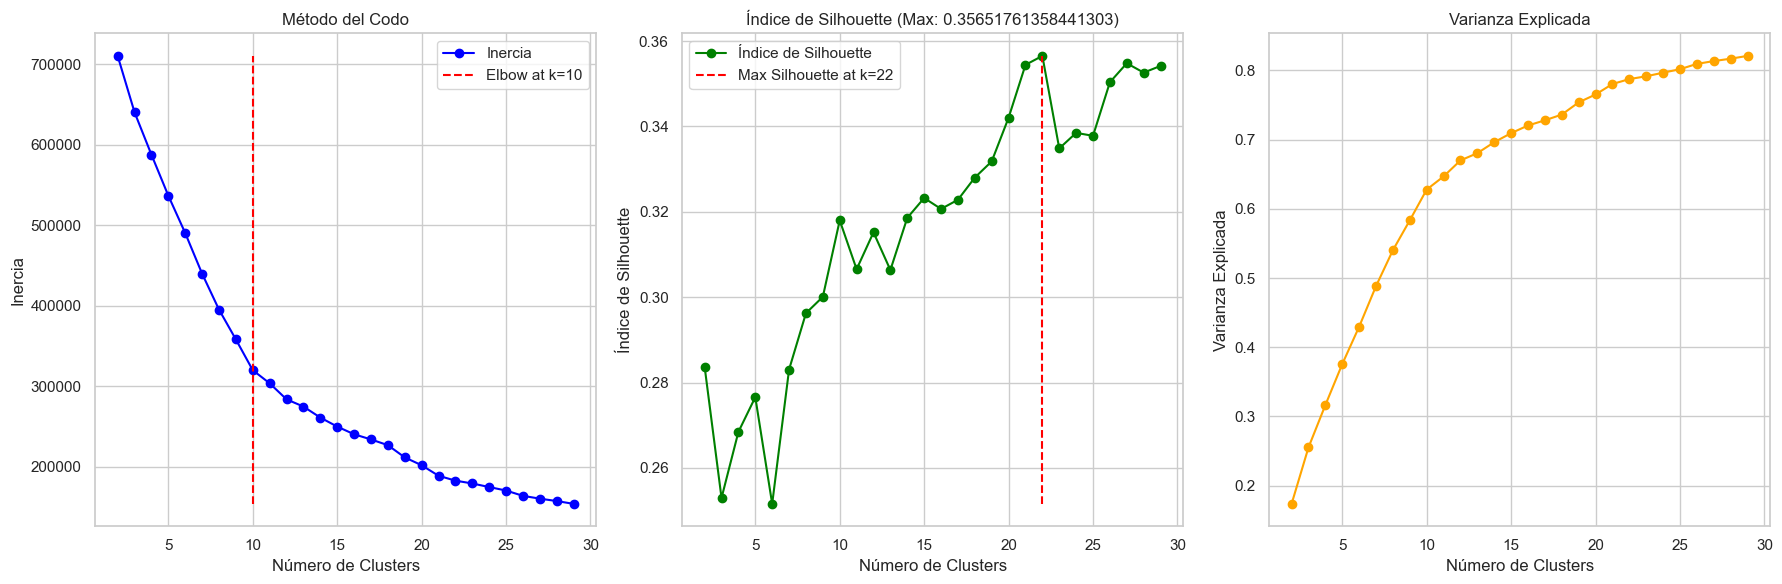

Número óptimo de clusters según el método del codo: 10
Mejor índice de Silhouette: 0.35651761358441303 con K=22


In [44]:
graficar_metricas_clustering(K_range, inertias, silhouette_scores, varianza_explicada, optimal_k, max_silhouette, clusters_max_silhouette)

**Interpretación de resultados**

* El método del codo sugiere que el número óptimo de clusters es 10, lo que significa que con este valor, se captura un 62% de la varianza en los datos. Esto indica que los 10 clusters identificados por K-means logran un buen equilibrio entre simplicidad del modelo y captura de la estructura de los datos.
* El índice de Silhouette de 0.3565 sugiere que, cuando se usan 22 clusters, hay una mejor cohesión dentro de los clusters y mayor separación entre ellos, en comparación con otros valores de K. Con 22 clusters, se captura un 78% de la varianza en los datos, lo que significa que esta configuración logra explicar una mayor cantidad de la variabilidad en los datos, mejorando la calidad de la segmentación en comparación con K=10.

Dados estos resultados realizamos una validación cruzada para comparar cómo se comporta el modelo con valores de K tanto en términos de segmentación como de estabilidad, con los valores obtenidos por el metodo del codo (10) y el indice de Silhouete (22). 

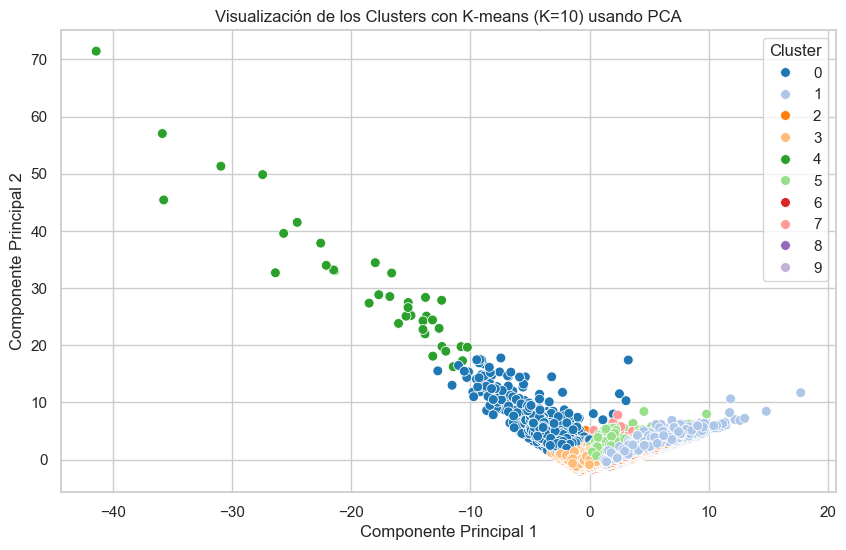

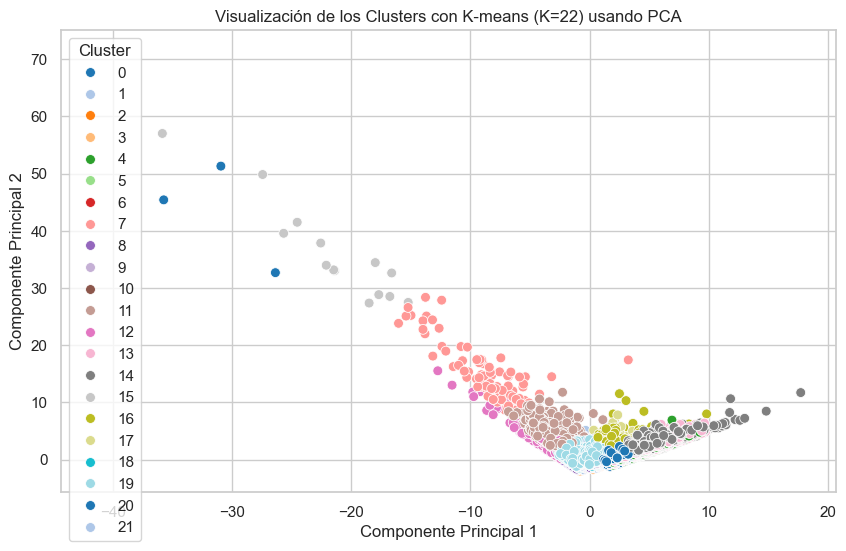

Resultados para K=10:
Índice de Silhouette: 0.3185543457631123
Inercia (Varianza Explicada): 320065.8286326085
------------------------------
Resultados para K=22:
Índice de Silhouette: 0.35651761358441303
Inercia (Varianza Explicada): 182925.4537324576
------------------------------


In [48]:
# Definición de los valores de K a evaluar
k_values = [10, 22]

# Diccionario para almacenar los resultados
resultados = {}

for k in k_values:
    # Configuración del modelo de K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    
    # Ajuste del modelo y predecir los clusters
    cluster_labels = kmeans.fit_predict(data_pca)
    
    # Cálculo del índice de Silhouette
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    
    # Obtención de la inercia (varianza explicada)
    inercia = kmeans.inertia_
    
    # Almacenamiento de los resultados en el diccionario
    resultados[k] = {
        "Silhouette": silhouette_avg,
        "Inercia (Varianza Explicada)": inercia,
        "Centros": kmeans.cluster_centers_
    }

    # Almacenar los clusters en nuevas columnas en el dataframe 'data_cleaned_region'
    data_cleaned_region[f'k_means_k{k}'] = cluster_labels

    # Creación de un DataFrame con los resultados para guardar en CSV
    results_df = pd.DataFrame({
        'Componente_Principal_1': data_pca[:, 0],
        'Componente_Principal_2': data_pca[:, 1],
        'Cluster': cluster_labels
    })

    # Guardado de los resultados en un archivo CSV
    data_cleaned_region.to_csv(f'../data/clusters/clusters_kmeans_k{k}.csv', index=False)

    # Gráfica de los clusters usando Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=cluster_labels, palette='tab20', s=50)
    plt.title(f'Visualización de los Clusters con K-means (K={k}) usando PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Cluster')
    plt.show()

# Resultados de la validación cruzada
for k, metrics in resultados.items():
    print(f"Resultados para K={k}:")
    print(f"Índice de Silhouette: {metrics['Silhouette']}")
    print(f"Inercia (Varianza Explicada): {metrics['Inercia (Varianza Explicada)']}")
    print("-" * 30)

**Interpretación de resultados**

*K=10*

* Cluster 0 y Cluster 1 parecen ser los grupos más grandes y densamente poblados, lo que podría sugerir que son los clusters que representan la mayoría de los hogares con características comunes.
* Cluster 3 y Cluster 4 muestran más dispersión, lo que indica que los puntos dentro de esos clusters tienen una mayor variabilidad interna.
* Algunos clusters, como 6, 7, y 8, están más separados, lo que sugiere que podrían estar representando grupos de hogares con características más distintivas.
* El índice de Silhouette de 0.3185 sugiere que, aunque la segmentación es aceptable, hay margen para mejorar. Algunos clusters podrían estar demasiado cerca entre sí, lo que refleja la posibilidad de hogares con características similares en varios grupos.

*K=22*
* En la gráfica de K=22, puedes observar una mayor separación entre algunos clusters en comparación con K=10. Esto indica que el modelo con 22 clusters es capaz de identificar grupos más pequeños y específicos de hogares.
* Clusters como 0, 5 y 7 son notablemente distintos y están más aislados, lo que podría sugerir que representan grupos de hogares con características más marcadas o inusuales.
* Otros clusters, como 9, 13, 14, y 15, están más agrupados, lo que sugiere que podrían tener características más similares entre ellos, pero aún lo suficientemente distintas para formar clusters separados.

K=22 ofrece una mejor segmentación en comparación con K=10, tanto en términos de índice de Silhouette como de inercia. Esto sugiere que con más clusters se está capturando mejor la diversidad y las variaciones entre los hogares, identificando patrones más finos en los dats, lo que podría conducir a una segmentación más precisa y detallada, e intervenciones más dirigidas y efectivas.

Nuestro siguiente paso es realizar el análisis y evaluación de los otros algoritmos (K-medoides, clustering jerárquico, DBSCAN) y comparar los resultados para elegir el algoritmo que proporcione los clusters más definidos y útiles para la segmentación de los hogares en el proyecto.

## K-Medoides

Para nuestro proyecto de segmentación de hogares probamos el algoritmo K-medoides como parte del análisis de clustering. K-medoides es una técnica robusta que permite agrupar hogares en clusters, utilizando puntos representativos de cada grupo llamados medoides, en lugar de centros ideales como en K-means. Este enfoque es menos sensible a outliers y puede proporcionar una segmentación más estable en situaciones donde los datos pueden presentar valores extremos. 

Se realizaron pruebas con diferentes valores de K clusters y diferentes métricas de distancia, como `Euclidean`, `Manhattan` y `Cosine` para identificar la mejor manera de medir la proximidad entre los hogares y así obtener una segmentación precisa y útil para diseñar estrategias de intervención más específicas y efectivas por parte de CARE. `Chebyshev` es descartada porque se enfoca solo en la dimensión con la mayor diferencia, lo que no refleja la complejidad de los datos de los hogares en este contexto.

### Selección del número de clústeres y métricas de distancia

Se aplicó un muestreo del 50% del dataset original para reducir la carga computacional y evitar que el kernel se cierre debido al gran tamaño del dataset completo, permitiendo probar diferentes valores de K de con las metricas `euclidean`, `manhattan` y `cosine` y determinar el k optimo y la mejor metrica para aplicara sobre el 100% del dataframe. 

In [13]:
def kmedoids_clustering_analysis(data_pca, metric):
    """
    Función para realizar análisis de clustering con K-medoides usando una métrica de distancia específica.

    Parámetros:
    - data_pca_sampled: DataFrame con los datos reducidos por PCA.
    - metric: Métrica de distancia a utilizar ('euclidean', 'manhattan', 'cosine').
    """
    # Rango de clusters a probar
    K_range = range(2, 30)

    # Listas para almacenar las métricas
    inertias = []
    silhouette_scores = []
    varianza_explicada = []

    # Calcular la inercia total para el dataset reducido (con 1 cluster)
    kmedoids_total = KMedoids(n_clusters=1, metric=metric, random_state=42)
    kmedoids_total.fit(data_pca)
    inercia_total = kmedoids_total.inertia_

    # Probar diferentes números de clusters
    for k in K_range:
        kmedoids = KMedoids(n_clusters=k, metric=metric, random_state=42)
        kmedoids_labels = kmedoids.fit_predict(data_pca)

        inercia_k = kmedoids.inertia_
        inertias.append(inercia_k)

        silhouette_scores.append(silhouette_score(data_pca, kmedoids_labels))

        varianza = 1 - inercia_k / inercia_total
        varianza_explicada.append(varianza)

    # Determinar el número óptimo de clusters (método del codo)
    kneedle = KneeLocator(K_range, inertias, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow

    max_silhouette = max(silhouette_scores)
    clusters_max_silhouette = K_range[silhouette_scores.index(max_silhouette)]

    # Imprimir la métrica actual
    print(f"\nResultados para la métrica de distancia: {metric}\n")

    # Graficar los resultados para la métrica actual
    graficar_metricas_clustering(K_range, inertias, silhouette_scores, varianza_explicada, optimal_k, max_silhouette, clusters_max_silhouette)

#### Métrica: `Euclidean`

Medimos la distancia entre dos puntos en el espacio euclidiano dados que tenemos datos continuos y numéricos, como ingresos, tamaño del hogar, etc.


Resultados para la métrica de distancia: euclidean



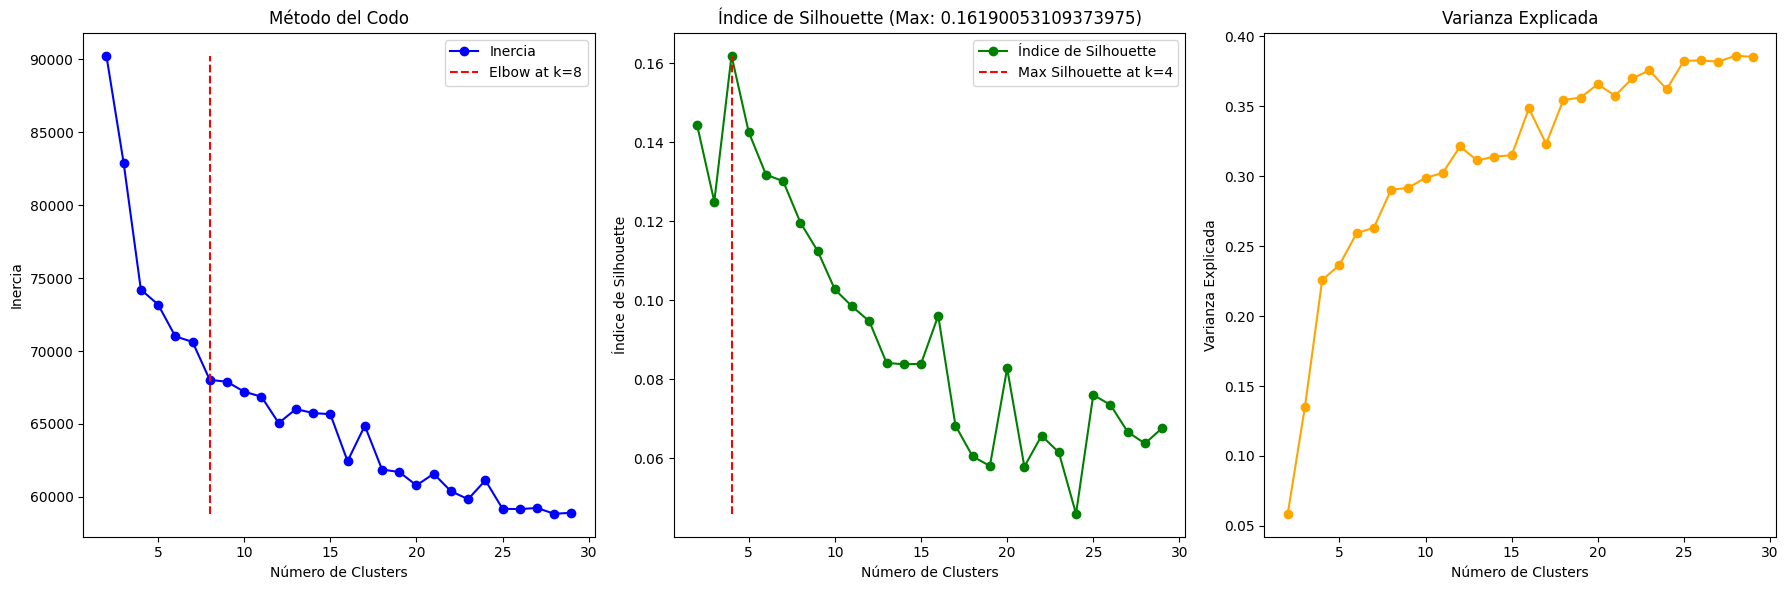

Número óptimo de clusters según el método del codo: 8
Mejor índice de Silhouette: 0.16190053109373975 con K=4


In [14]:
# Muestreo del 50% del dataset original (antes de PCA)
data_sampled = data_scaled_df.sample(frac=0.50, random_state=42)

# Aplicación de PCA a la muestra reducida
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_pca_sampled = pca.fit_transform(data_sampled)

# Llamado a la función de clustering con una métrica específica
kmedoids_clustering_analysis(data_pca_sampled, metric='euclidean')

#### Métrica: `Manhattan`

Calculamos la distancia entre dos puntos como la suma de las distancias absolutas en cada dimensión porque es robusta ante outliers y podria funcionar bien si los datos tienen distribuciones irregulares o si hay valores atípicos.


Resultados para la métrica de distancia: manhattan



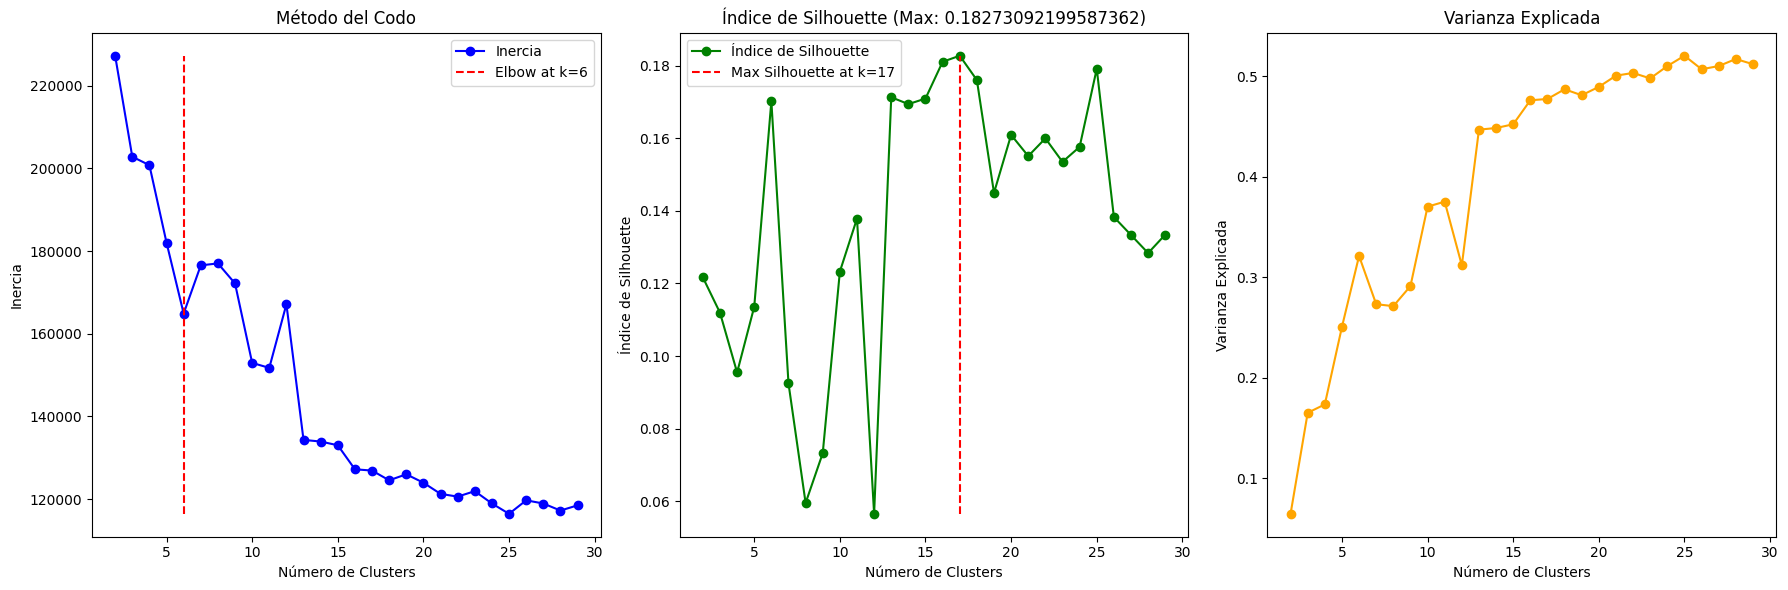

Número óptimo de clusters según el método del codo: 6
Mejor índice de Silhouette: 0.18273092199587362 con K=17


In [15]:
# Muestreo del 50% del dataset original (antes de PCA)
data_sampled = data_scaled_df.sample(frac=0.50, random_state=42)

# Aplicación de PCA a la muestra reducida
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_pca_sampled = pca.fit_transform(data_sampled)

# Llamado a la función de clustering con una métrica específica
kmedoids_clustering_analysis(data_pca_sampled, metric='manhattan')

#### Métrica: `Cosine`

Medimos la similitud entre dos vectores, considerando el ángulo entre ellos, dado que tenemos datos vectoriales, tras la reducción con PCA. Puede ayudarnos a medir la similitud en términos de la dirección de las variables, más que de la magnitud. Esto podría ser relevante si las relaciones entre las variables no dependen tanto de sus valores absolutos, sino de sus proporciones o patrones.


Resultados para la métrica de distancia: cosine



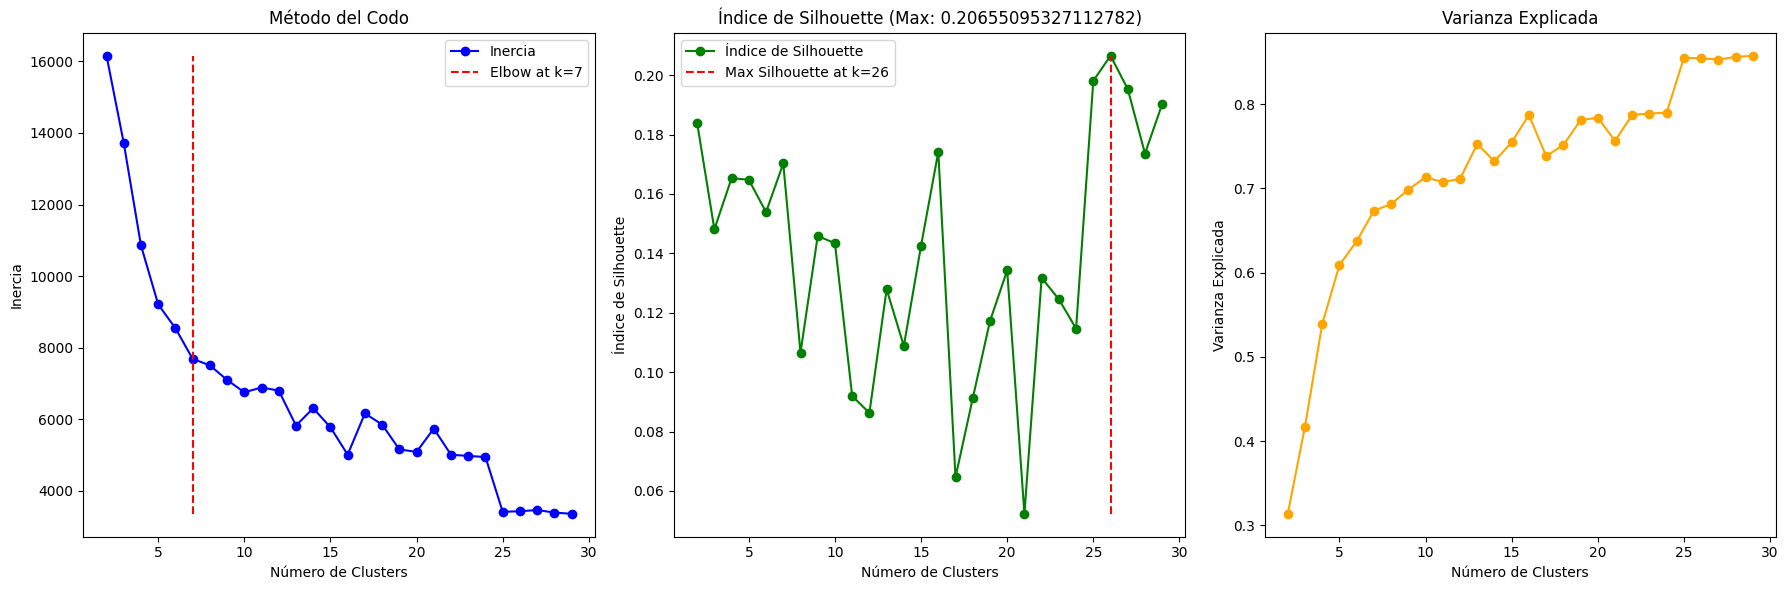

Número óptimo de clusters según el método del codo: 7
Mejor índice de Silhouette: 0.20655095327112782 con K=26


In [16]:
# Muestreo del 50% del dataset original (antes de PCA)
data_sampled = data_scaled_df.sample(frac=0.50, random_state=42)

# Aplicación de PCA a la muestra reducida
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_pca_sampled = pca.fit_transform(data_sampled)

# Llamado a la función de clustering con una métrica específica
kmedoids_clustering_analysis(data_pca_sampled, metric='cosine')

**Interpretación de resultados**

* Métrica `euclidean`: El índice de Silhouette es relativamente bajo (0.1619), lo que indica que los clusters no están bien definidos o no están claramente separados. Con 8 clusters, se explica solo el 29% de la varianza, lo que sugiere que el agrupamiento con esta métrica no captura bien la estructura del dataset.Aunque el método del codo sugiere 8 clusters, el índice de Silhouette indica que K=4 ofrece una mejor cohesión interna.
* Métrica `manhattan`: El índice de Silhouette es más alto que en el caso de Euclidean (0.1827), lo que sugiere que los clusters son aún mas cohesionados.
Con 17 clusters, se explica un 48% de la varianza. El método del codo indica 6 clusters, mientras que el índice de Silhouette sugiere que con K=17 los clusters tienen una mejor separación.
* Métrica `cosine`: El índice de Silhouette es el más alto entre las tres métricas (0.2065), aunque sigue siendo moderado. Esto indica que los clusters están mejor separados en comparación con las otras métricas. Con 7 clusters, se explica el 65% de la varianza, lo cual es considerablemente mejor que con Euclidean y Manhattan. El método del codo sugiere 7 clusters, pero el índice de Silhouette indica que con K=26 se obtiene una mejor segmentación en cuanto a cohesión interna.

La métrica Cosine parece ser la más adecuada, ya que presenta el mejor índice de Silhouette y la mayor cantidad de varianza explicada, lo que indica que los clusters están mejor definidos en comparación con Euclidean y Manhattan. Aunque el método del codo sugiere 7 clusters, el índice de Silhouette con K=25 es mejor. Dados estos resultados realizamos una validación cruzada para comparar cómo se comporta el modelo con valores de K tanto en términos de segmentación como de estabilidad, con los valores obtenidos por el metodo del codo (7) y el indice de Silhouete (26). 

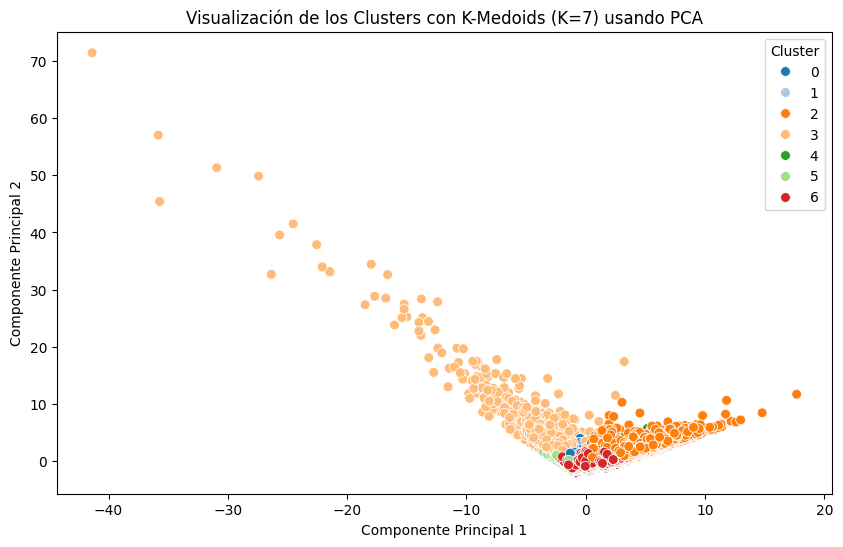

Resultados para K=7:
Índice de Silhouette: 0.3751527896577068
Inercia (Varianza Explicada): 16230.768678151057
------------------------------


In [14]:
# Correr K=7 primero
k = 7

# Configuración del modelo de K-medoids
kmedoids = KMedoids(n_clusters=k, metric='cosine', random_state=42)
kmedoids_labels = kmedoids.fit_predict(data_pca)
    
# Calcular el índice de Silhouette para evaluar la calidad del clustering
silhouette_avg = silhouette_score(data_pca, kmedoids_labels, metric='cosine')

# Obtención de la inercia (varianza explicada)
inercia = kmedoids.inertia_

# Asignar los clusters a una nueva columna en el dataframe
data_cleaned_region[f'k_medoids_k{k}'] = kmedoids_labels

# Guardar los resultados en un archivo CSV
data_cleaned_region.to_csv(f'../data/clusters/clusters_kmedoids_k{k}.csv', index=False)

# Gráfica de los clusters usando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmedoids_labels, palette='tab20', s=50)
plt.title(f'Visualización de los Clusters con K-Medoids (K={k}) usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# Mostrar los resultados
print(f"Resultados para K={k}:")
print(f"Índice de Silhouette: {silhouette_avg}")
print(f"Inercia (Varianza Explicada): {inercia}")
print("-" * 30)

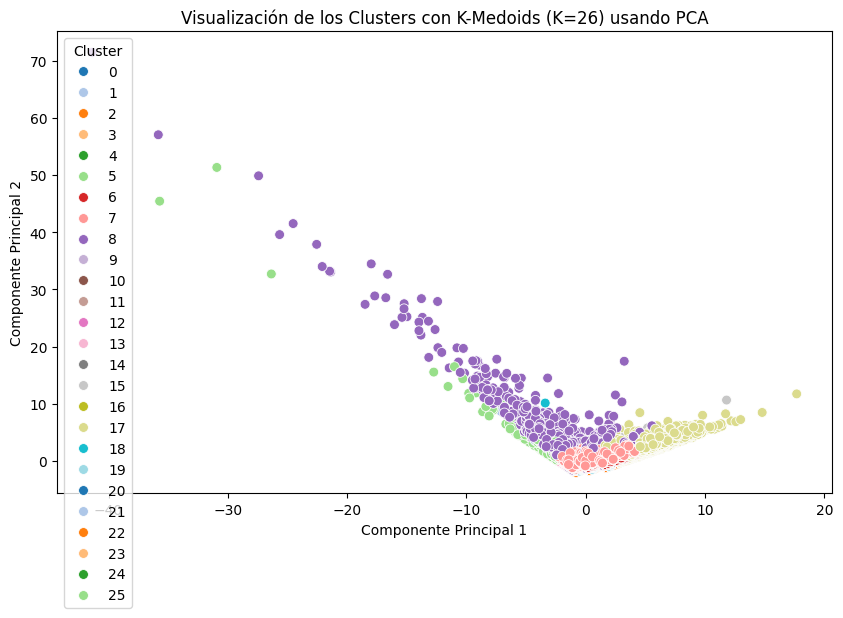

Resultados para K=26:
Índice de Silhouette: 0.32266608197167096
Inercia (Varianza Explicada): 10016.851990881432
------------------------------


In [15]:
# Correr K=7 primero
k = 26

# Configuración del modelo de K-medoids
kmedoids = KMedoids(n_clusters=k, metric='cosine', random_state=42)
kmedoids_labels = kmedoids.fit_predict(data_pca)
    
# Calcular el índice de Silhouette para evaluar la calidad del clustering
silhouette_avg = silhouette_score(data_pca, kmedoids_labels, metric='cosine')

# Obtención de la inercia (varianza explicada)
inercia = kmedoids.inertia_

# Asignar los clusters a una nueva columna en el dataframe
data_cleaned_region[f'k_medoids_k{k}'] = kmedoids_labels

# Guardar los resultados en un archivo CSV
data_cleaned_region.to_csv(f'../data/clusters/clusters_kmedoids_k{k}.csv', index=False)

# Gráfica de los clusters usando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmedoids_labels, palette='tab20', s=50)
plt.title(f'Visualización de los Clusters con K-Medoids (K={k}) usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# Mostrar los resultados
print(f"Resultados para K={k}:")
print(f"Índice de Silhouette: {silhouette_avg}")
print(f"Inercia (Varianza Explicada): {inercia}")
print("-" * 30)

**Interpretación de resultados**

*K=7:*
* El índice de Silhouette es de 0.375, lo que indica una segmentación aceptable, donde los clusters están moderadamente bien definidos y separados entre sí, aunque aún podría haber cierta superposición o dispersión entre algunos grupos. 
* En cuanto a la inercia (varianza explicada), se obtuvo un valor de 16,230.77, que indica la suma de distancias cuadradas entre los puntos y los centros de sus respectivos clusters. 
* La visualización en 2D muestra cómo los puntos están agrupados en distintas regiones del espacio PCA. Se puede observar que el cluster 0 está separado del resto, mientras que los clusters 1, 2 y 3 están más juntos, lo que podría indicar algunas similitudes entre ellos. La concentración de puntos en la parte baja sugiere que la mayoría de los datos están agrupados en esos clusters, mientras que algunos puntos más dispersos pertenecen a otros clusters pequeños.

*K=26*
* Se obtuvo un índice de Silhouette de 0.3227, lo que indica una segmentación moderada. Este valor sugiere que los puntos dentro de los clusters están razonablemente cohesionados y son funcionales, aunque podría haber cierta superposición entre algunos grupos.
* La inercia (varianza explicada) es de 10,016.85, lo que indica que las distancias cuadradas entre los puntos y sus centroides son relativamente bajas, lo que muestra que los puntos dentro de los clusters están bien agrupados alrededor de sus respectivos centros. Esto es indicativo de una segmentación aceptable en términos de la minimización de la varianza.
* En la gráfica, se puede observar que los clusters están dispersos a lo largo de las dos primeras componentes principales obtenidas mediante PCA. Los puntos se distribuyen en diferentes regiones del gráfico, con algunos clusters más compactos y otros un poco más dispersos. Es notable que la mayoría de los puntos están concentrados hacia la parte inferior derecha del gráfico, lo que podría representar una concentración de hogares con características similares. También se observa que algunos clusters (como los clusters 0 y 5) están más dispersos y podrían estar capturando segmentos con más variabilidad en sus características.

De las dos interpretaciones, K=7 parece ser una mejor opción por las siguientes razones:

* Índice de Silhouette: Aunque el valor de Silhouette para K=7 (0.375) es ligeramente mayor que el de K=26 (0.3227), lo que sugiere que los clusters están más bien definidos y menos superpuestos en K=7.
* Inercia: Si bien la inercia en K=26 es menor (10,016.85), lo que indica una menor distancia promedio entre los puntos y sus centros, la diferencia de inercia no compensa la caída en el índice de Silhouette. En K=7, la inercia de 16,230.77 aún es razonable considerando la mejor cohesión de los clusters.
* Distribución de Clusters: Visualmente, K=7 proporciona una segmentación más clara y menos dispersa. En K=26, aunque se capturan más segmentos de hogares, algunos clusters parecen menos cohesionados y más dispersos, lo que podría hacer que sea más difícil interpretar las diferencias entre grupos. En K=7, los clusters parecen más concentrados, lo que facilita su interpretación y el diseño de intervenciones más efectivas.

## Clustering Jerárquico

En este proyecto, se aplicó el Clustering Jerárquico como uno de los métodos de segmentación de los hogares, evaluando su capacidad para identificar grupos con características similares y comparando los resultados con otros algoritmos de clustering.

### Parámetros a evaluar `n_clusters`, `linkage` y `afinity`

**Enlace Ward:**
Como buscamos una segmentación precisa de los hogares, este método podría funcionar bien, ya que trata de formar clusters que minimicen la dispersión interna. En el contexto de la pobreza y desigualdad, probablemente quieras encontrar grupos con hogares homogéneos en términos de ingresos o condiciones socioeconómicas. En este sentido, la Afinidad recomendada sería la `Distancia Euclidiana`, que mide la distancia recta entre dos puntos, es una opción ideal para este método, ya que los datos probablemente están distribuidos en un espacio euclidiano continuo después del PCA.

**Enlace Complete:**
Dado que puede haber hogares que sean extremos o muy diferentes, este método puede ayudar a formar clusters que separen claramente esos hogares "extremos" de los demás. Esto puede ser útil para evitar solapamientos en los clusters y  que los clusters estén bien separados. La afinidad a probar en este caso sería tanto `Euclidiana`. 

**Enlace Average:**
 Si los hogares tienen una relación más continua en términos de pobreza y desigualdad, este método puede ser útil para formar clusters donde los hogares dentro de cada grupo son similares en promedio, sin que los valores extremos tengan un gran impacto. Esto puede ser importante ya que se espera que algunos hogares tengan características mixtas (por ejemplo, algunos con altos ingresos pero con muchos dependientes). La afinidad recomendada es `Cosine` podría ser una buena opción, ya que mide la similitud entre los hogares en función de los ángulos entre sus vectores (independientemente de las magnitudes). 

 **Enlace Single**
 Este enlace no se probó. En un contexto de segmentación de hogares, el enlace sencillo podría no ser tan útil, ya que los clusters tienden a ser largos y poco compactos. Es probable que no sea lo más adecuado si buscas clusters claramente separados.

In [68]:
def clustering_jerarquico(data, metodo, metric='euclidean'):
    # Crear el linkage con la métrica permitida en `linkage` (como manhattan)
    Z = linkage(data, method=metodo, metric=metric)

    # Crear el dendrograma
    plt.figure(figsize=(10, 6))
    dendrogram(Z, no_labels=True)  # Se añade el parámetro no_labels=True para omitir las etiquetas
    plt.title(f'Dendrograma - Método: {metodo}, Métrica: {metric}')
    plt.ylabel('Distancia')
    plt.show()

    # Calcular el índice de Silhouette para diferentes números de clusters
    silhouette_scores = []
    K_range = range(2, 30)

    for k in K_range:
        # Aplicar AgglomerativeClustering solo con el método (sin métrica)
        clustering = AgglomerativeClustering(n_clusters=k, linkage=metodo)  
        labels = clustering.fit_predict(data)

        # Calcular el índice de Silhouette
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

    # Gráfico del índice de Silhouette
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, silhouette_scores, 'bo-', color='green', label='Índice de Silhouette')
    plt.vlines(silhouette_scores.index(max(silhouette_scores)) + 2, ymin=min(silhouette_scores), ymax=max(silhouette_scores), linestyles='dashed', color='red', label=f'Max Silhouette at K={silhouette_scores.index(max(silhouette_scores)) + 2}')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Índice de Silhouette')
    plt.title(f'Índice de Silhouette (Max: {max(silhouette_scores):.3f})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Mejor índice de Silhouette: {max(silhouette_scores)} en K={silhouette_scores.index(max(silhouette_scores)) + 2}")


#### Enlace `ward` y Métrica `euclidean`

In [74]:
# Muestreo del 50% del dataset original (antes de PCA)
data_sampled = data_scaled_df.sample(frac=0.50, random_state=42)

# Aplicación de PCA a la muestra reducida
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_pca_sampled = pca.fit_transform(data_sampled)


Probando método: ward y métrica: euclidean


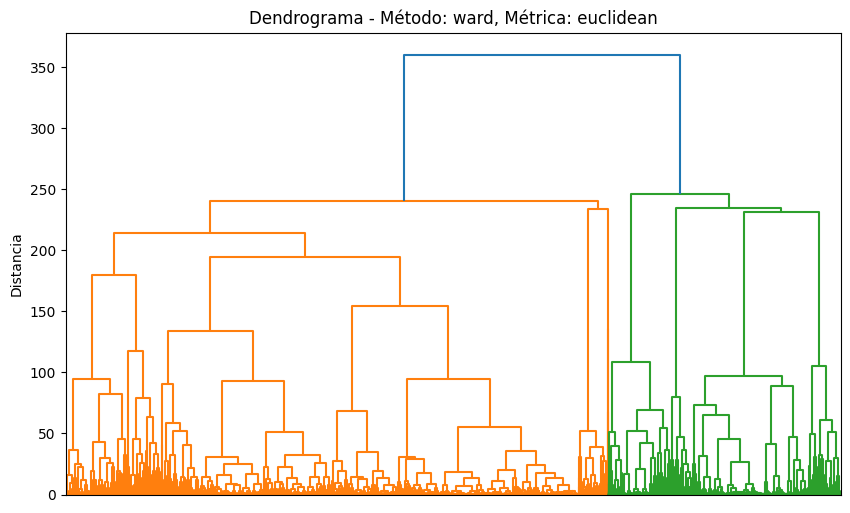

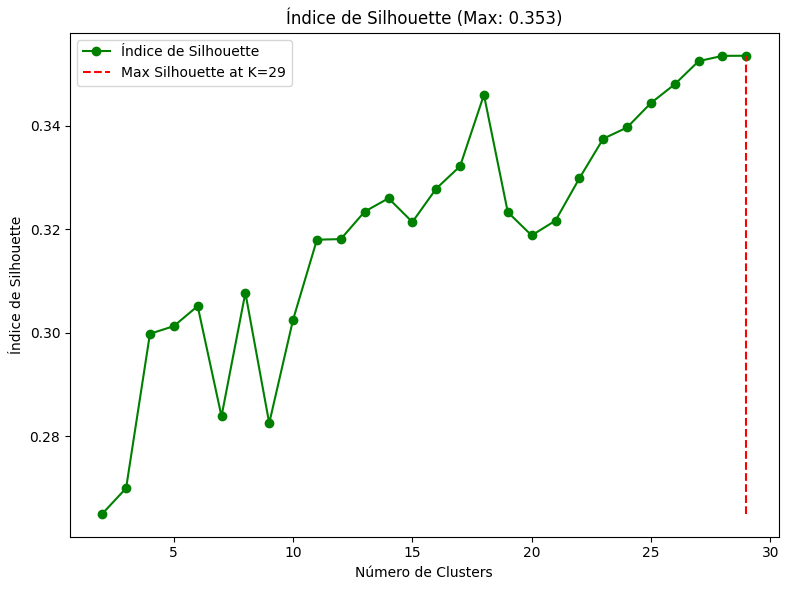

Mejor índice de Silhouette: 0.3534792462968984 en K=29


In [75]:
pruebas = [ ('ward', 'euclidean')]        # Ward solo funciona con euclidean

for metodo, metric in pruebas:
    print(f'\nProbando método: {metodo} y métrica: {metric}')
    clustering_jerarquico(data_pca_sampled, metodo, metric)

#### Enlace `complete` y Métrica `euclidean`


Probando método: complete y métrica: euclidean


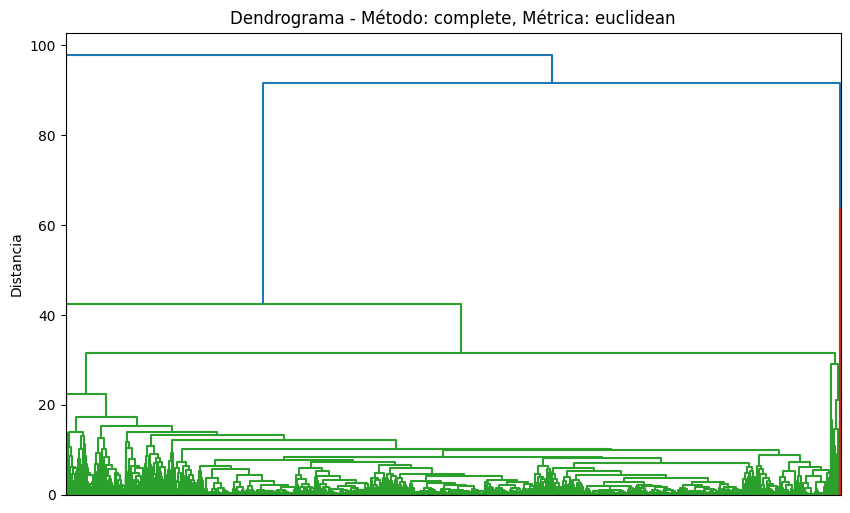

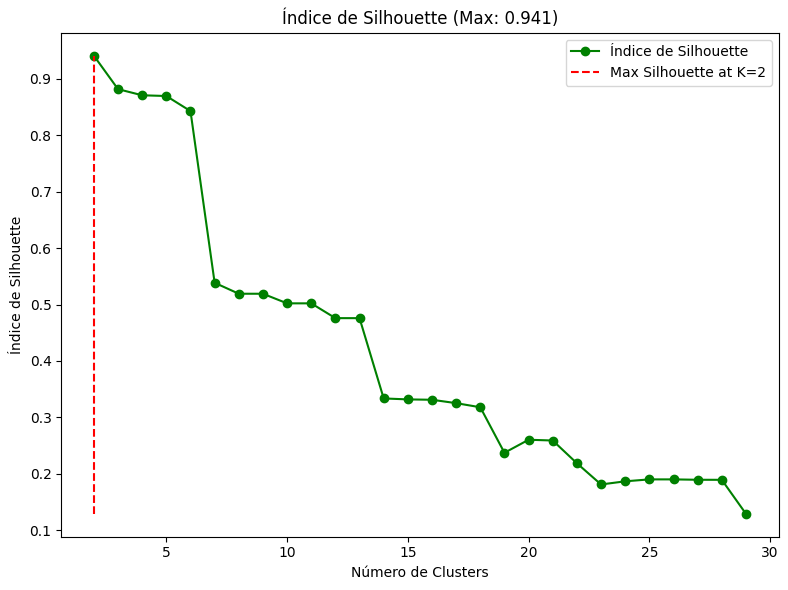

Mejor índice de Silhouette: 0.9409424017383268 en K=2


In [76]:
pruebas = [('complete', 'euclidean') ]     
  
for metodo, metric in pruebas:
    print(f'\nProbando método: {metodo} y métrica: {metric}')
    clustering_jerarquico(data_pca_sampled, metodo, metric)

#### Enlace `average` y Métrica `cosine`


Probando método: average y métrica: cosine


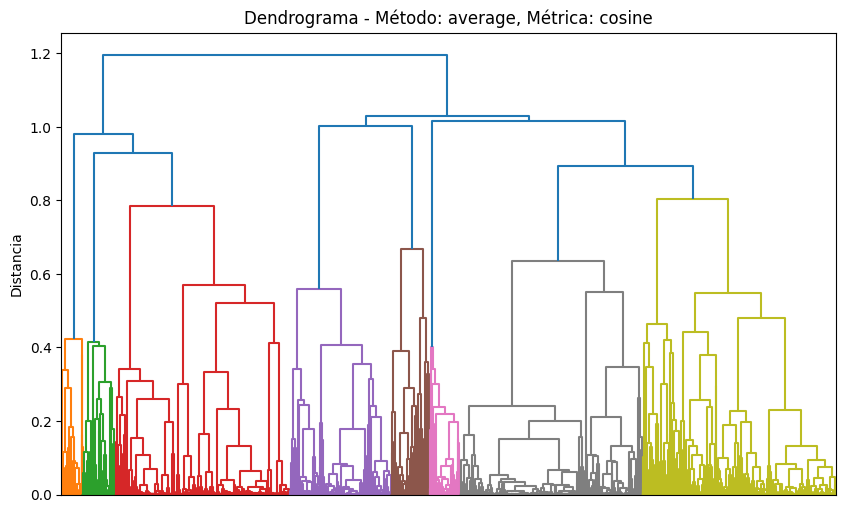

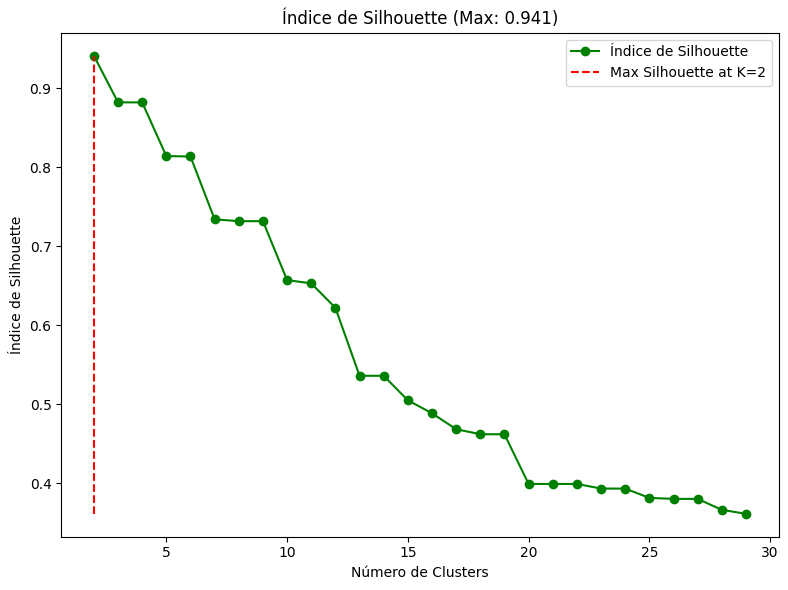

Mejor índice de Silhouette: 0.9411434698422662 en K=2


In [72]:
pruebas = [    ('average', 'cosine'), ]

for metodo, metric in pruebas:
    print(f'\nProbando método: {metodo} y métrica: {metric}')
    clustering_jerarquico(data_pca_sampled, metodo, metric)

** Interpretación de resultados**

*Ward y Distancia Euclidiana:*
* En este análisis de clustering jerárquico utilizando el método de enlace Ward y la distancia euclidiana, el número óptimo de clusters según el índice de Silhouette fue de 29, con un valor máximo de Silhouette de 0.336. Esto sugiere que con 29 clusters, el modelo logra una segmentación relativamente adecuada, donde los puntos dentro de cada cluster están cohesionados y las separaciones entre clusters son razonables.
* A pesar de que el valor de Silhouette más alto se obtuvo con 29 clusters, los valores de Silhouette en la región de los 9 clusters no difieren de manera drástica del máximo obtenido, y una configuración de 9 clusters podría ofrecer una buena representación de la estructura de los datos sin añadir una complejidad innecesaria. Al observar el dendrograma, es posible identificar varios puntos en los que se pueden formar grupos naturales, y 9 clusters capturan una segmentación lo suficientemente granular como para proporcionar información detallada sin perder claridad.

*Complete con distancia euclidiana*
* El dendrograma aquí muestra una estructura con menos divisiones grandes. 
* A pesar de que el índice de Silhouette es alto, con 0.941 para K=2, esto sugiere que la mayoría de los datos caen en un gran cluster con un pequeño número de puntos fuera. Esto puede no ser ideal para un análisis más detallado de los hogares, ya que 2 clusters no segmentan suficientemente los datos.
* Este método parece estar agrupando de manera muy general.

*Average con distancia cosine:*
* Este dendrograma tiene una estructura interesante, con varias ramas que indican posibles clusters bien diferenciados. 
* El índice de Silhouette es muy alto para K=2, pero, al igual que con complete-euclidean, esto probablemente esté agrupando la mayoría de los puntos en un solo cluster, lo que puede no ser lo ideal.
* Este método puede ser útil si los datos tienen similitudes más relativas que absolutas, pero para este caso, los clusters parecen muy dispersos.

Dado el contexto del análisis de hogares, es importante lograr una segmentación que capture las diferencias clave sin crear demasiados clusters. El método Ward con euclidean parece la mejor opción, ya que equilibra la segmentación compacta y clara con la cohesión de los clusters. Aunque el índice de Silhouette sugiere 29 clusters, sería posible usar 9 clusters al cortar el dendrograma a una altura adecuada (100-120), manteniendo una buena separación visual de los clusters en el dendrograma.

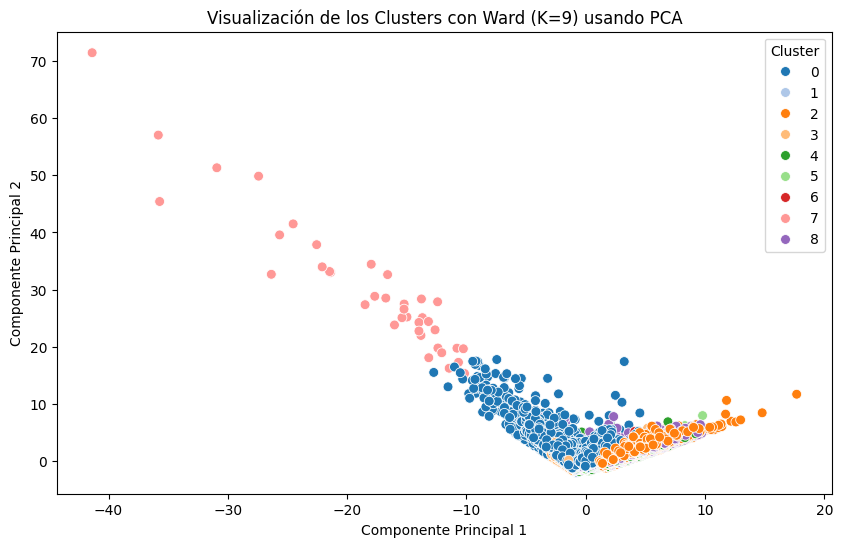

Resultados para K=9:
Índice de Silhouette: 0.2610742092339383
------------------------------


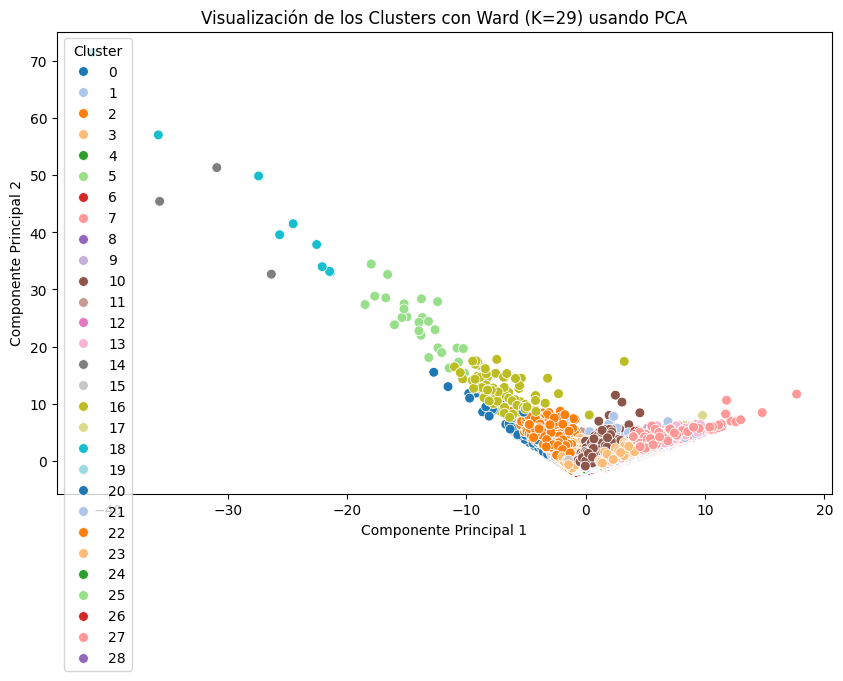

Resultados para K=29:
Índice de Silhouette: 0.3582536671551212
------------------------------


In [79]:
# Configurar los valores de clusters a probar
k_values = [9, 29]

# Diccionario para almacenar los resultados
resultados = {}

# Iterar sobre los valores de k (número de clusters)
for k in k_values:
    # Configuración del modelo de Agglomerative Clustering con Ward linkage y Euclidean distance
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    
    # Ajustar el modelo y predecir los clusters
    cluster_labels = clustering.fit_predict(data_pca)
    
    # Calcular el índice de Silhouette
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    
    # Asignar los clusters a una nueva columna en el dataframe
    data_cleaned_region[f'ward_euclidean_k{k}'] = cluster_labels
    
    # Guardar los resultados en un archivo CSV
    data_cleaned_region.to_csv(f'../data/clusters/clusters_hierarchical_ward_euclidean_k{k}.csv', index=False)

    # Gráfica de los clusters usando Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=cluster_labels, palette='tab20', s=50)
    plt.title(f'Visualización de los Clusters con Ward (K={k}) usando PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Cluster')
    plt.show()

    # Mostrar los resultados
    print(f"Resultados para K={k}:")
    print(f"Índice de Silhouette: {silhouette_avg}")
    print("-" * 30)

**Interpretación de resultados**

*K=9*
* Clusters 0, 1 y 2 están bien separados visualmente en el espacio PCA, mostrando que representan grupos de datos con características distintivas.
* Clusters 3, 4, 5, y 6 aparecen más dispersos y cercanos entre sí, lo que podría indicar una mayor similitud entre estos grupos o cierta ambigüedad en la segmentación.
* El cluster 0 es el más grande y parece captar la mayoría de los datos, mientras que otros clusters como 7 y 8 son más pequeños y dispersos.
* La concentración de puntos en la parte baja sugiere que la mayoría de los hogares están agrupados en estos clusters centrales, mientras que otros clusters más dispersos están capturando segmentos más pequeños y especializados.
* K=9 parece ofrecer una segmentación funcional, aunque el índice de Silhouette muestra que podría haber mejores opciones para mejorar la cohesión interna de los grupos.

*K=29*
* La visualización en 2D, basada en PCA, muestra que con K=29 los clusters están bastante dispersos a lo largo de las dos primeras componentes principales.
* Es notable cómo algunos clusters, especialmente aquellos cercanos al origen (como los clusters 0, 1, 4, y 5), parecen representar grandes grupos de datos compactos. Otros clusters, más alejados, están más dispersos y podrían representar hogares con características más atípicas o variadas.
* K=29 clusters parece capturar más detalles y variaciones dentro de los datos, lo que puede ser útil para segmentar hogares en subgrupos específicos. 

# DBSCAN

#### Identificación de los parametros `eps` y `min_samples`

In [26]:
dimensiones = data_pca.shape[1]
dimensiones

11

Valor óptimo de eps: 6.3574489243835375


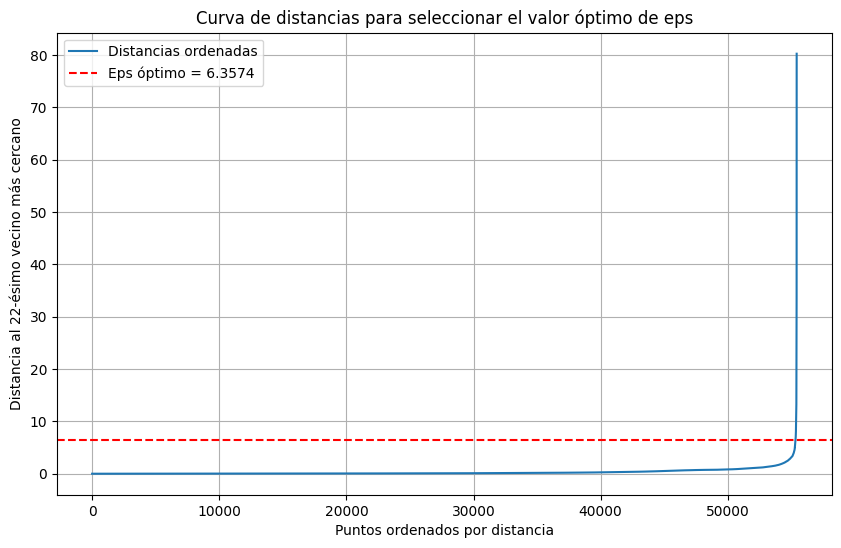

In [19]:
# Definición de min_samples para DBSCAN
min_samples = 2*dimensiones

# Cálculo las distancias a los min_samples vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_scaled)  # data_scaled es tu dataset escalado
distances, indices = neighbors_fit.kneighbors(data_scaled)

# Ordenar las distancias
distances = np.sort(distances[:, min_samples-1])  # min_samples-1 para obtener la distancia al min_samples vecino

# Usar KneeLocator para detectar el "codo" en la curva
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

# Valor óptimo de eps según el "codo"
optimal_eps = distances[kneedle.elbow]
print(f"Valor óptimo de eps: {optimal_eps}")

# Graficar la curva y el punto donde se detectó el "codo"
plt.figure(figsize=(10, 6))
plt.plot(distances, label='Distancias ordenadas')
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Eps óptimo = {optimal_eps:.4f}')  # Línea horizontal en el valor de eps
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino más cercano')
plt.title('Curva de distancias para seleccionar el valor óptimo de eps')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
eps_values = [0.2, 0.4, 0.6, 0.8, 1]
min_samples_values = [5, 10, 15, 20, 25]

for eps in eps_values:
    for min_samples in min_samples_values:
        # Aplicar DBSCAN con diferentes combinaciones de eps y min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        dbscan_labels = dbscan.fit_predict(data_pca)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        print(f"DBSCAN con eps={eps}, min_samples={min_samples}")
        print(f"Numero de clusters encontrados: {n_clusters}")
        print(f"Numero de puntos de ruido (outliers): {n_noise}")
        
        # Calcular el índice de Silhouette si hay más de 1 cluster
        if n_clusters > 1:
            silhouette_avg = silhouette_score(data_pca, dbscan_labels)
            print(f"Índice de Silhouette: {silhouette_avg}")
        else:
            print("No se puede calcular el índice de Silhouette con menos de 2 clusters.")
        
        print("-" * 30)

DBSCAN con eps=0.2, min_samples=5
Numero de clusters encontrados: 556
Numero de puntos de ruido (outliers): 6026
Índice de Silhouette: 0.17502634157699906
------------------------------
DBSCAN con eps=0.2, min_samples=10
Numero de clusters encontrados: 321
Numero de puntos de ruido (outliers): 9306
Índice de Silhouette: 0.15114847930670133
------------------------------
DBSCAN con eps=0.2, min_samples=15
Numero de clusters encontrados: 239
Numero de puntos de ruido (outliers): 11483
Índice de Silhouette: 0.14373597386835396
------------------------------
DBSCAN con eps=0.2, min_samples=20
Numero de clusters encontrados: 193
Numero de puntos de ruido (outliers): 13160
Índice de Silhouette: 0.13526314268008482
------------------------------
DBSCAN con eps=0.2, min_samples=25
Numero de clusters encontrados: 171
Numero de puntos de ruido (outliers): 14565
Índice de Silhouette: 0.11623430550976442
------------------------------
DBSCAN con eps=0.4, min_samples=5
Numero de clusters encontrado

**Interpretación de resultados**

* eps = 0.2: A medida que se aumenta el valor de `min_samples`, el número de clusters disminuye considerablemente, pero también aumenta la cantidad de puntos de ruido. El índice de Silhouette disminuye desde 0.175 a 0.116, lo que indica que estos valores de eps generan clusters con menor cohesión y separación entre ellos. Este valor de `eps` genera muchos clusters pequeños, pero con baja calidad (índices de Silhouette bajos) y muchos puntos de ruido.

* eps = 0.4: Este rango genera menos clusters (entre 184 y 438), y el índice de Silhouette mejora hasta un máximo de 0.227. La cantidad de puntos de ruido es relativamente alta, aunque menor que en `eps` = 0.2. Aunque este rango mejora un poco la calidad de los clusters en comparación con `eps` = 0.2, sigue generando más ruido y clusters de baja calidad.

* eps = 0.6: Aquí el índice de Silhouette mejora considerablemente, alcanzando hasta 0.315 con min_samples = 15 y valores cercanos con otros `min_samples`.
El número de clusters se reduce (máximo de 159) y la cantidad de puntos de ruido es relativamente manejable. Este valor de `eps` parece ser más apropiado, ya que genera clusters con mejor cohesión y separación, y el índice de Silhouette está en un rango aceptable (entre 0.29 y 0.31).

* eps = 0.8: El índice de Silhouette alcanza su mejor valor en esta serie de pruebas (0.370 con `min_samples` = 15). Los clusters son más compactos, con una cantidad moderada de puntos de ruido. Este valor de eps es el mejor en términos de calidad de clustering. Genera menos clusters, pero con mejor cohesión y separación.

* eps = 1: Aunque el número de clusters es menor, los índices de Silhouette se mantienen altos, con un máximo de 0.370 para `min_samples` = 20. Sin embargo, la cantidad de clusters es baja (entre 37 y 49). Este valor de `eps` también es bueno, pero pareciera que `eps` = 0.8 puede ser más adecuado.

* Comparación de índices de Silhouette: Los valores de `eps` que generaron los mejores índices de Silhouette son `eps` = 0.8 y `eps` = 1, con `min_samples` en torno a 15-25. El índice de Silhouette más alto es de 0.370, lo que sugiere una segmentación razonable de los datos. El número de clusters generados con estos valores de `eps` es suficiente para ofrecer una buena segmentación sin crear demasiados puntos de ruido.

* Conclusión: Se seleccionan este conjunto de parámetros genera una buena cantidad de clusters, un índice de Silhouette alto, y una cantidad manejable de puntos de ruido, lo que sugiere que es el mejor equilibrio entre segmentación y calidad de clusters.
Selección de los mejores parámetros:
    - eps = 1 y min_samples = 20:
    - Número de clusters: 37

In [30]:
# Definir los parámetros de DBSCAN
eps = 1
min_samples = 20

# Aplicar DBSCAN al dataset reducido (o completo si no estás usando PCA)
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(data_pca)  # data_pca es tu dataset reducido por PCA o completo si lo prefieres

# Contar el número de clusters y puntos de ruido
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

# Verificar si es posible calcular el índice de Silhouette
if n_clusters > 1:
    silhouette_avg = silhouette_score(data_pca, dbscan_labels)
    print(f"Índice de Silhouette: {silhouette_avg}")
else:
    print("No se puede calcular el índice de Silhouette con menos de 2 clusters.")

# Asignar los clusters a una nueva columna en el dataframe (ignorar puntos de ruido con label -1)
data_cleaned_region['dbscan_clusters'] = dbscan_labels

# Guardar los resultados en un archivo CSV
data_cleaned_region.to_csv('../data/clusters/clusters_dbscan_euclidean.csv', index=False)

Índice de Silhouette: 0.3705604466059218


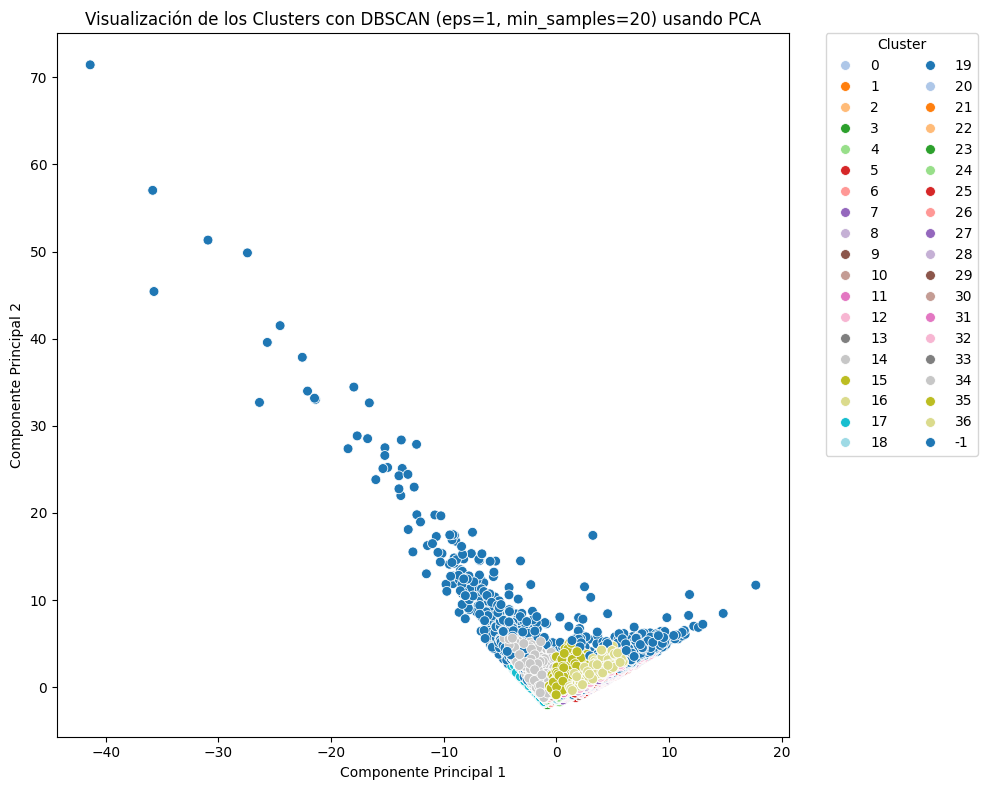

Número de clusters encontrados: 37
Número de puntos de ruido (outliers): 1572


In [31]:
# Gráfica de los clusters usando Seaborn con una leyenda mejorada en dos columnas
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=dbscan_labels, palette='tab20', s=50)

# Personalización del título y etiquetas
plt.title(f'Visualización de los Clusters con DBSCAN (eps={eps}, min_samples={min_samples}) usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mejorar la leyenda en dos columnas
handles, labels = plt.gca().get_legend_handles_labels()
# Ordenar los clusters, donde -1 (outliers) se queda al final
order = [i for i in range(len(labels)) if labels[i] != '-1'] + [labels.index('-1')] if '-1' in labels else []
plt.legend([handles[idx] for idx in order], 
           [labels[idx] for idx in order], 
           title='Cluster', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           borderaxespad=0., 
           ncol=2)  # Aquí definimos que la leyenda tenga 2 columnas

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Mostrar los resultados
print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de puntos de ruido (outliers): {n_noise}")

**Interpretación de resultados**

* DBSCAN sobre los datos a los que se les aplicó la reducción de dimensionalidad con `eps`=1 y `min_samples`=20 ha logrado identificar 37 clusters con un buen índice de Silhouette, lo que sugiere una segmentación efectiva y una buena separación entre clusters.
* La cantidad de outliers (1572) es razonable y probablemente representa puntos que no se ajustan a los patrones dominantes en los datos.
* Aunque 0.37 no es el más alto de los índices observados, es adecuado para este tipo de algoritmo, dado que DBSCAN es más adecuado para capturar estructuras complejas basadas en la densidad.
* En cuanto a la gráfica de cluster: La mayor parte de los puntos están agrupados en un área densa en la región inferior del gráfico (entre los componentes principales -10 y 10 en el eje de la Componente Principal 1 y 0 y 20 en la Componente Principal 2). El cluster -1 (outliers) está representado por puntos dispersos, especialmente en la parte superior izquierda y dispersos por la gráfica.

# Conclusión Final y Selección del Modelo

Después de evaluar los cuatro algoritmos de clustering aplicados a los datos, se presentan las siguientes conclusiones:

**K-means:**
* K=10 tuvo un índice de Silhouette de 0.3185, mientras que K=22 mejoró ligeramente a 0.3565. Sin embargo, K=22 generó muchos clusters pequeños que, aunque más específicos, podrían no ser útiles para una intervención efectiva en este contexto.
* Conclusión: K=22 captura una segmentación más detallada, pero a costa de una mayor complejidad. Aunque el índice de Silhouette es decente, no logra superar significativamente a otros métodos.

**K-medoides:**
* K=7 mostró un índice de Silhouette de 0.375, mientras que K=26 cayó a 0.3227. K=7 tiene un balance favorable entre la cohesión y el tamaño de los clusters, lo que indica que es una opción sólida con menor complejidad.
* Conclusión: K=7 parece ser una buena opción debido a su índice de Silhouette más alto y clusters más definidos y menos dispersos. Proporciona una segmentación clara sin generar demasiada fragmentación.

**Clustering jerárquico:**
* K=9 ofreció un índice de Silhouette de 0.261, mientras que K=29 mejoró a 0.358, aunque con muchos más clusters. K=29 identifica segmentos más específicos, pero la dispersión de los clusters y la complejidad aumentada lo hacen menos atractivo para implementar intervenciones prácticas.
* Conclusión: K=29 ofrece más detalles, pero K=9 sería una mejor opción si buscamos simplicidad y fácil interpretación. Aun así, el índice de Silhouette para este método está por debajo de otras opciones.

**DBSCAN:**
* DBSCAN identificó 37 clusters con un índice de Silhouette de 0.37. Este valor es competitivo, y el algoritmo logró identificar grupos basados en densidad, lo que es útil para encontrar patrones en estructuras complejas. Sin embargo, 37 clusters podrían ser difíciles de manejar, y la interpretación sería más compleja.
* Conclusión: Aunque el rendimiento de DBSCAN es aceptable, su alta cantidad de clusters y el enfoque basado en la densidad puede generar complejidad para acciones prácticas.

### Modelo Seleccionado:

El K-medoides con K=7 es el modelo seleccionado por las siguientes razones:

* Mejor equilibrio: Proporciona un balance adecuado entre el número de clusters, la cohesión interna de los grupos (índice de Silhouette de 0.375), y la simplicidad para interpretar y accionar.
* Segmentación clara: Los clusters están bien definidos, con menos dispersión que en otros métodos, lo que facilita una interpretación más clara de los segmentos de hogares y permite diseñar estrategias de intervención específicas y eficaces.
* Manejabilidad: K=7 ofrece una segmentación suficientemente granular sin generar demasiada complejidad, a diferencia de los modelos con un mayor número de clusters (como K=29 o DBSCAN con 37 clusters).

Este modelo permitirá identificar grupos de hogares con características distintivas sin complicar demasiado la implementación de acciones de intervención por parte de CARE.